<a href="https://colab.research.google.com/github/pedrocalheiross/projeto-ciencia-de-dados/blob/main/desmatamento2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Ciência de Dados (2)

Pedro Barros de Souza Lima - pbsl@cin.ufpe.br

Pedro Calheiros de Araújo - pca@cin.ufpe.br

Dataset encontrado em: https://dados.gov.br/dados/conjuntos-dados/incendios-em-unidades-de-conservacao-federais

Arquivos importantes: https://www.gov.br/icmbio/pt-br/acesso-a-informacao/dados-abertos/arquivos/sistema-de-analise-e-monitoramento-da-efetividade-de-gestao-samge/dados-do-samge-1-identificacao-e-resultados.xlsx

###**Objetivos:**

1. Escolher uma das colunas dos dados utilizados no projeto 1 para predição (classificação ou regressão) ✅

2. Separar os	dados	em treinamento,	validação	e	teste ✅

3. Selecionar	4	algoritmos de acordo com a tarefa escolhida no passo	1	✅

4. Adicionar MLFlow no treinamento dos modelos para rastreamento ⛔

5. Executar uma ferramenta de seleção de hiper-parâmetros sobre o conjunto de validação ⛔
    1. Selecionar poucos hiper-parâmetros por algoritmo	(max.	3) ⛔
    2. Selecionar o modelo (algoritmo+valores de hiper-parâmetros) com melhor resultado na métrica de avaliação ⛔
    3. Executar o melhor modelo de cada algoritmo no conjunto de teste e selecionar o melhor modelo geral na métrica de avaliação ⛔

6. Realizar diagnóstico do melhor modelo geral da etapa 5 e melhorá-lo a partir do diagnóstico ⛔

* Bônus: Utilizar auto-sklearn, clustering para entendimento dos dados ⛔

### Imports

In [17]:
#!pip install mlflow

#!pip install auto-sklearn

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [18]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
import sklearn
from math import log10
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler #, MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
from random import randint
import logging
from imblearn.over_sampling import SMOTE

# Classificação
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Avaliação
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Bônus
#import autosklearn

### Funções

In [19]:
def analiseTipos(df:pd.DataFrame, feature:str = None):
  '''Para printar uma contagem dos tipos, incluindo valores <NAN>
  Caso o parâmentro "feature" não seja declarado, será feito o .dtypes do dataframe "df"'''
  if(feature):
    print(f'''Num <NAN>: {len(df[df[feature].isna()])}

{df[feature].apply(lambda x: type(x)).value_counts()}''')
  else:
    print(f'Num <NAN>: {len(df[df.isna()])}\n')
    print(df.dtypes)

In [20]:
def checkMetrics(test, pred, get_metrics:bool=True, display:list=None):

  labels = [0,1,2,3,4]
  acc = accuracy_score(test, pred)
  prc = precision_score(test, pred, labels=labels, average='macro')
  rcl = recall_score(test, pred, labels=labels, average='macro')
  f1s = f1_score(test, pred, labels=labels, average='macro')

  if(get_metrics):
    return acc, prc, rcl, f1s

  print(f'''Acurácia: {acc:.11f}
Precisão: {prc:.11f}
Recall: {rcl:.11f}
F1-Score: {f1s:.11f}
''')
  print("Matriz de Confusão:")

  cm = confusion_matrix(test, pred, labels=labels)

  if(display):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display)
  else:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)

  disp.plot()

  plt.show()

In [21]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

## Pré-análise dos dados

### prep

Coleta dos dados principais:

In [23]:
#PATH = '/content/tabela_de_desmatamento_ucs.xlsx'
PATH = 'tabela_de_desmatamento_ucs.xlsx'

df = pd.read_excel(PATH, sheet_name=0, header=1)
df = df.drop(df.index[-1])
df = df.assign(bioma = "Amazônia")
for b in ['Mata Atlântica', 'Pampa', 'Cerrado', 'Caatinga']: # tirei o pantanal porque dados estavam incompletos
  temp = pd.read_excel(PATH, sheet_name=b, header=1)
  temp = temp.drop(temp.index[-1])
  temp = temp.assign(bioma = b)
  df = pd.concat([df, temp], ignore_index=True)

In [24]:
df.columns

Index([                  'cnuc', 'unidade de conservação',
                   'área_ha_uc',               'Até 2007',
                           2008,                     2009,
                           2010,                     2011,
                           2012,                     2013,
                           2014,                     2015,
                           2016,                     2017,
                           2018,                     2019,
                           2020,                     2021,
                           2022,                     2023,
                        'TOTAL',                  'bioma',
                     'Até 2000',            '2001 a 2004',
                           2006,                     2002,
                           2004],
      dtype='object')

---
#### Verificação da coluna 'TOTAL' e remoção de registros pré-2008


In [25]:
cols = ['Até 2007', 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022, 2023, 'Até 2000', '2001 a 2004', 2006, 2002, 2004]

df.assign(total_check=lambda x: x.loc[:,cols].sum(axis=1))[['unidade de conservação', 'bioma', 'TOTAL', 'total_check']]

,unidade de conservação,bioma,TOTAL,total_check
0,APA do Igarapé Gelado,Amazônia,9146.70,9146.70
1,APA do Tapajós,Amazônia,137537.01,137537.01
2,APA dos Campos de Manicoré,Amazônia,215.43,215.43
3,ARIE Projeto Dinâmica Biológica de Fragmento F...,Amazônia,74.26,74.26
4,ARIE Seringal Nova Esperança,Amazônia,1777.85,1777.85
...,...,...,...,...
316,REBIO Guaribas,Caatinga,20.16,20.16
317,RESEX do Batoque,Caatinga,105.36,105.36
318,RESEX Prainha do Canto Verde,Caatinga,72.90,72.90
319,REVIS da Ararinha Azul,Caatinga,111.72,111.72


Se você for comparar os valores da soma e do TOTAL, pelo pandas vai dizer que alguns não são iguais, mas se compararmos visualmente, claramente não há diferença. Provavelmente é uma diferença na leitura dos floats ou na computação da soma. Não há diferenças relevantes.

De qualquer forma ela será removida porque, ao final do tratamento dos dados, ela não será útil, já que parte dos valores que se somavam para dar o valor em TOTAL foi retirado, ou foi adicionado algum valor no lugar de dados ausentes.

In [26]:
df = df.drop(columns=['Até 2007', '2001 a 2004', 'Até 2000', 2002, 2006, 2004, 'TOTAL'])

---
#### Verificação de Unidades de Conservação (UC) duplicadas

In [27]:
cols = ['unidade de conservação', 'bioma']
#df.loc[:,cols].groupby(by='unidade de conservação').aggregate('count').sort_values(by='bioma', ascending=False).head(18)

UCs repetidas são compostas por 2 biomas. É importante deixá-las como instâncias separadas porque a área desmatada é diferente entre biomas da mesma UC.

In [28]:
df[df['unidade de conservação'] == 'PARNA Cavernas do Peruaçu']

,cnuc,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,bioma
259,0000.00.0135,PARNA Cavernas do Peruaçu,56448.64549,8.68,NaN,26.68,NaN,75.26,7.09,1.01,0.0,0.00,10.12,12.59,0.00,0.0,0.00,0.0,NaN,Cerrado
303,0000.00.0135,PARNA Cavernas do Peruaçu,56448.64549,142.74,NaN,86.69,4.96,NaN,241.22,82.60,NaN,78.57,41.40,61.49,13.29,5.1,15.49,0.0,NaN,Caatinga


---
#### Coleta & Integração das Unidades Federativas ao dataset principal
(+ rápida análise + remoção de duplicatas)


In [29]:
#dfid = pd.read_excel('/content/dados-do-samge-1-identificacao-e-resultados.xlsx').loc[:,['Nome da UC', 'UF']]
dfid = pd.read_excel('dados-do-samge-1-identificacao-e-resultados.xlsx').loc[:,['Nome da UC', 'UF']]

Não foi apresentado aqui no código, mas na planilha original, a diferença entre essas duplicatas são apenas o ano do registro, que é importante para dados referentes ao gerenciamento das UCs.

Como nós só precisamos do(s) estado(s) onde estão localizadas, não tem porquê manter essas duplicatas:  

In [30]:
dfid = dfid.drop_duplicates()
df['unidade de conservação'] = df['unidade de conservação'].apply(lambda x: x.upper())
df = pd.merge(df, dfid, how='inner', right_on='Nome da UC', left_on='unidade de conservação').drop(columns=['Nome da UC'])
#df[df['unidade de conservação'] == 'APA DA BACIA DO RIO DESCOBERTO']

---
#### Definição de tipos

In [31]:
df.dtypes

cnuc                       object
unidade de conservação     object
área_ha_uc                float64
2008                      float64
2009                      float64
2010                      float64
2011                      float64
2012                      float64
2013                      float64
2014                      float64
2015                      float64
2016                      float64
2017                      float64
2018                      float64
2019                      float64
2020                      float64
2021                      float64
2022                      float64
2023                      float64
bioma                      object
UF                         object
dtype: object

In [32]:
co = ['AL', 'PE', 'PB', 'RN', 'SE', 'CE', 'PI', 'MA', 'BA', # NE  (1) 0-8
      'TO', 'PA', 'AC', 'RR', 'RO', 'AP', 'AM',             # N   (1) 9-15
      'MT', 'MS', 'DF', 'GO',                               # CO  (1) 16-19
      'PR', 'RS', 'SC',                                     # S   (1) 20-22
      'ES', 'RJ', 'MG', 'SP',                               # SE  (1) 23-26
      'AL, PE', 'CE, PI',                     # NE      (2) 27-28
      'BA, TO',                               # NE, N   (2) 29
      'AM, RO', 'AM, PA', 'AM, RR', 'AP, PA', # N       (2) 30-33
      'AM, MT', 'AM, MT, RO',                 # N, CO   (2)(3) 34-35
      'DF, GO',                               # CO      (2) 36
      'MS, PR',                               # CO, S   (2) 37
      'RS, SC',                               # S       (2) 38
      'RJ, SP'                                # SE      (2) 39
      ]

df['UF'] = df['UF'].astype(pd.api.types.CategoricalDtype(categories=co))

Não acho que vale a pena aumentar o número de UCs para que cada instância tenha apenas uma UF relacionada. Elas já foram dividas de acordo com seus biomas, além disso, não temos como relacionar um bioma a um estado exclusivamente porque biomas não respeitam fronteiras artificiais.

In [33]:
df['bioma'] = df['bioma'].astype('category')
df['bioma'].cat.categories

Index(['Amazônia', 'Caatinga', 'Cerrado', 'Mata Atlântica', 'Pampa'], dtype='object')

Criação da coluna "região":

Apenas 4 UCs estão presentes em mais de uma região.

In [34]:
uf2reg = ['NE', 'N', 'CO', 'S', 'SE', 'NE', 'NE, N', 'N', 'N, CO', 'CO', 'CO, S', 'S', 'SE']

df['região'] = pd.cut(df.UF.cat.codes, [0, 9, 16, 20, 23, 27, 29, 30, 34, 36, 37, 38, 39, 40], ordered=False, labels=uf2reg, right=False)

# Define and apply arbitrary category order
# Essa ordem foi decidida porque se quiser fazer uma análise de bioma presentes
# nas regiões, por exemplo, Norte e/ou Centro-Oeste, é só especificar o intervalo
# dos índices de ambas as regiões, que também irá incluir UCs presentes em ambas
# ao mesmo tempo, df['região'].cat.categories[1:4] => ['N', 'N, CO', 'CO'],
# ou até df['região'].cat.categories[3:6] => ['N', 'N, CO', 'CO']
co = ['NE', 'NE, N', 'N', 'N, CO', 'CO', 'CO, S', 'S', 'SE']

df['região'] = df['região'].astype(pd.api.types.CategoricalDtype(categories=co))

df['região'].value_counts()

região
N        82
NE       57
SE       38
S        27
CO       12
N, CO     2
CO, S     1
NE, N     1
Name: count, dtype: int64

---
####Tratamento de dados ausentes

In [35]:
cols = ['unidade de conservação', 'área_ha_uc', 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 'bioma']
#df[cols].head()

Quantidades de dados nulos por bioma e ano:

In [36]:
dfna = pd.DataFrame(index=df.bioma.cat.categories, columns=range(2008,2024))
dfna = dfna.transform(lambda x: [df.loc[(df.bioma==x.name), col].isna().sum() for col in range(2008,2024)], axis=1)
dfna = dfna.assign(num_total=lambda x: df.bioma.value_counts())
dfna

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,num_total
Amazônia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,87
Caatinga,0,28,0,0,28,0,0,28,0,0,0,0,0,0,0,28,28
Cerrado,0,33,0,33,0,0,0,0,0,0,0,0,0,0,0,33,33
Mata Atlântica,0,70,0,0,70,0,0,70,0,0,0,0,0,0,0,70,70
Pampa,0,2,0,0,2,0,0,2,0,0,0,0,0,0,0,2,2


Colunas NAN por biomas:
* Amazônia:
  * Any NAN: 2023 (25NAN x 62NUM)
  * All NAN:
* Caatinga:
  * Any NAN: 2009, 2012, 2015, 2023
  * All NAN: 2009, 2012, 2015, 2023
* Cerrado:
  * Any NAN: 2009, 2011, 2023
  * All NAN: 2009, 2011, 2023
* Mata Atlântica:
  * Any NAN: 2009, 2012, 2015, 2023
  * All NAN: 2009, 2012, 2015, 2023
* Pampa:
  * Any NAN: 2009, 2012, 2015, 2023
  * All NAN: 2009, 2012, 2015, 2023

In [37]:
df.loc[:,2023].isna().sum() / len(df)

0.7181818181818181

Aproximadamente 72% dos registros de 2023 são nulos, então serão removidos.

In [38]:
df = df.drop(columns=[2023])

Como a maioria das colunas de anos faltantes estão entre colunas com dados declarados, achei melhor que esses dados faltantes fossem substituídos pela média das duas colunas vizinhas, indicando um aumento/diminuição gradual da quantidade de hectares desmatados, ao invés de simplesmente dizer que, por exemplo, não houve desmatamento para todas as UCs do bioma da Pampa no ano de 2009.

In [39]:
cols = [2009, 2012, 2015]
df.loc[(df.bioma.cat.codes.isin([1,3,4])), cols] = df.loc[(df.bioma.cat.codes.isin([1,3,4])), cols].apply(lambda x: (df[(x.name + 1)] + df[(x.name - 1)])/2)
cols = [2009, 2011]
df.loc[(df.bioma.cat.codes==2), cols] = df.loc[(df.bioma.cat.codes==2), cols].apply(lambda x: (df[(x.name + 1)] + df[(x.name - 1)])/2)
cols = list(range(2008, 2023))

#### Normalização e Discretização

In [40]:
scaler = StandardScaler()
#df_norm = df.loc[:,(['área_ha_uc']+cols)].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1,1)))

df_norm = pd.DataFrame(scaler.fit_transform(df[cols]), columns=cols)
df_norm['área_ha_uc'] = scaler.fit_transform(np.array(df['área_ha_uc']).reshape(-1,1))

colsa = ['área_ha_uc'] + cols

df_norm['bioma'] = df['bioma'].copy()

As colunas normalizadas não seguem distribuição gaussiana.

In [41]:
df_norm.describe()

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,área_ha_uc
count,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02,220.000000,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02,220.000000,2.200000e+02
mean,3.027881e-17,-1.614870e-17,3.229740e-17,-8.074349e-18,-5.652044e-17,6.055762e-18,-2.826022e-17,1.614870e-17,-8.074349e-18,0.000000,-8.074349e-18,-4.844610e-17,8.074349e-18,2.422305e-17,0.000000,-1.291896e-16
std,1.002281e+00,1.002281e+00,1.002281e+00,1.002281e+00,1.002281e+00,1.002281e+00,1.002281e+00,1.002281e+00,1.002281e+00,1.002281,1.002281e+00,1.002281e+00,1.002281e+00,1.002281e+00,1.002281,1.002281e+00
min,-2.411852e-01,-1.950873e-01,-1.719694e-01,-2.887491e-01,-2.751946e-01,-1.832701e-01,-2.469846e-01,-1.776210e-01,-1.953284e-01,-0.235780,-2.178445e-01,-1.956222e-01,-1.944161e-01,-1.799297e-01,-0.200067,-5.286977e-01
25%,-2.411852e-01,-1.950873e-01,-1.719694e-01,-2.887491e-01,-2.751946e-01,-1.832701e-01,-2.469846e-01,-1.776210e-01,-1.953284e-01,-0.235780,-2.178445e-01,-1.956222e-01,-1.944161e-01,-1.799297e-01,-0.200067,-5.080258e-01
50%,-2.345923e-01,-1.866430e-01,-1.622976e-01,-2.859758e-01,-2.698296e-01,-1.807170e-01,-2.463713e-01,-1.765120e-01,-1.936902e-01,-0.235059,-2.170910e-01,-1.920719e-01,-1.926140e-01,-1.797652e-01,-0.200067,-4.038971e-01
75%,-1.362561e-01,-1.401371e-01,-1.173074e-01,-2.011347e-01,-2.033755e-01,-1.491607e-01,-1.896150e-01,-1.423247e-01,-1.554789e-01,-0.187863,-1.851505e-01,-1.606854e-01,-1.596718e-01,-1.577661e-01,-0.175741,-1.263387e-02
max,1.142739e+01,1.148140e+01,1.315629e+01,8.963003e+00,9.307065e+00,1.115757e+01,8.787245e+00,1.218252e+01,1.053878e+01,9.315896,1.064459e+01,9.907319e+00,1.122500e+01,1.160804e+01,8.606931,6.622432e+00


<Axes: >

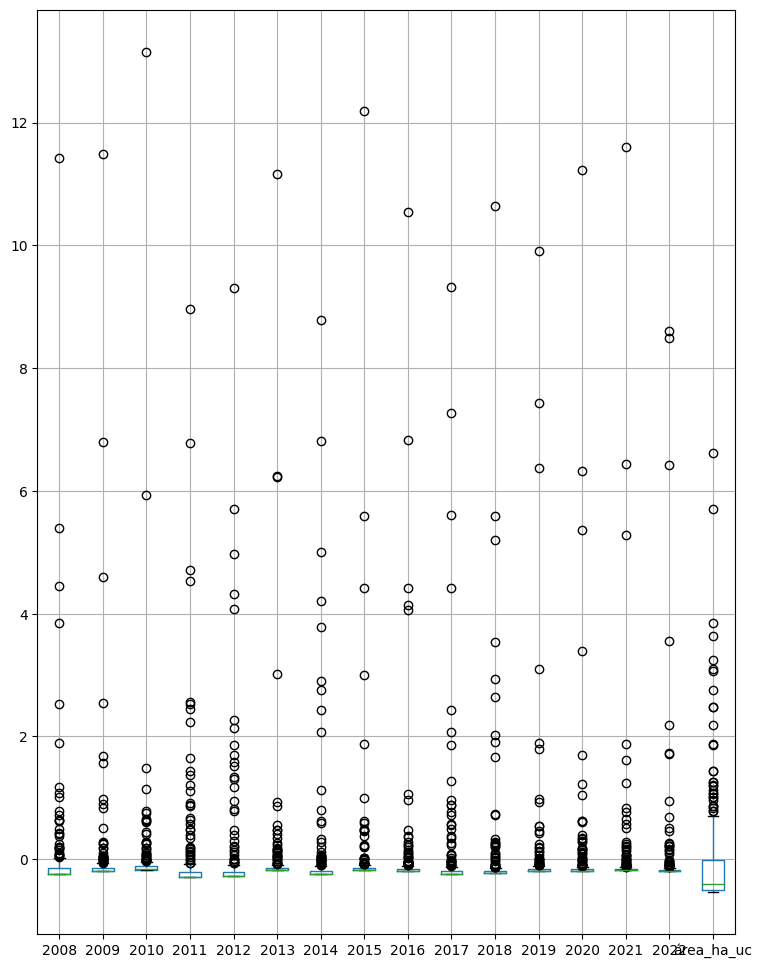

In [42]:
df_norm.boxplot(figsize=(9,12))

Essa versão normalizada do dataset será usada para o treinamento do classificador Support Vector Machine (SVM).

Uma das utilizadas seria a reposição de dados ausentes, que poderiam ser repostos pelo knn-inputer. Porém, pela particularidade da forma em que os dados ausentes estavam presentes, o grupo optou por usar outras técnicas para inputação de dados, tornando o knn-inputer irrelevante, e a normalização sem sentido.

In [43]:
dfd = df.copy()
q1 = df['área_ha_uc'].quantile(q=0.33)
q2 = df['área_ha_uc'].quantile(q=0.67)

dfd = dfd.assign(tamanho_área = 'pequena')
dfd.loc[(dfd['área_ha_uc'] > q1), ['tamanho_área']] = 'médio'
dfd.loc[(dfd['área_ha_uc'] > q2), ['tamanho_área']] = 'grande'
dfd['tamanho_área'] = dfd['tamanho_área'].astype('category')
dfd['tamanho_área'] = dfd['tamanho_área'].cat.codes
dfd.head()

,cnuc,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,...,2017,2018,2019,2020,2021,2022,bioma,UF,região,tamanho_área
0,0000.00.0022,APA DO IGARAPÉ GELADO,2.071467e+04,119.53,0.00,5.15,0.00,0.00,10.63,0.00,...,0.00,0.00,9.81,23.75,7.68,14.29,Amazônia,PA,N,1
1,0000.00.0268,APA DO TAPAJÓS,2.040336e+06,1648.94,1523.54,829.74,1352.57,2238.81,3246.37,2872.94,...,3229.61,3895.20,6552.78,6963.76,10646.08,11140.01,Amazônia,PA,N,0
2,0000.00.3407,APA DOS CAMPOS DE MANICORÉ,1.521325e+05,0.00,24.53,4.32,16.52,0.00,0.00,0.00,...,26.83,11.19,40.52,0.00,20.45,29.66,Amazônia,AM,N,1
3,0000.00.0044,ARIE SERINGAL NOVA ESPERANÇA,2.573984e+03,13.01,25.32,28.75,34.40,222.00,26.89,132.50,...,61.09,55.34,70.91,57.78,119.10,61.31,Amazônia,AC,N,2
4,0000.00.3131,ESEC ALTO MAUÉS,6.665559e+05,0.00,16.64,31.22,0.00,0.00,0.00,0.00,...,0.00,0.00,45.94,5.56,33.46,145.82,Amazônia,AM,N,0


A discretização também foi um ponto discutido entre a dupla, porém chegamos à conclusão que a discretização não faz sentido para as análises feitas neste projeto, podendo ser útil apenas na 2ª etapa do projeto, onde será feito o uso de classificadores e/ou regressores.

#### Detecção de outrliers e Limpeza de dados

Boxplot dos dados de desmatamento em cada ano. Os valores dos dados não são acumulativos, e sua unidade é Hectare (ha).

<Axes: >

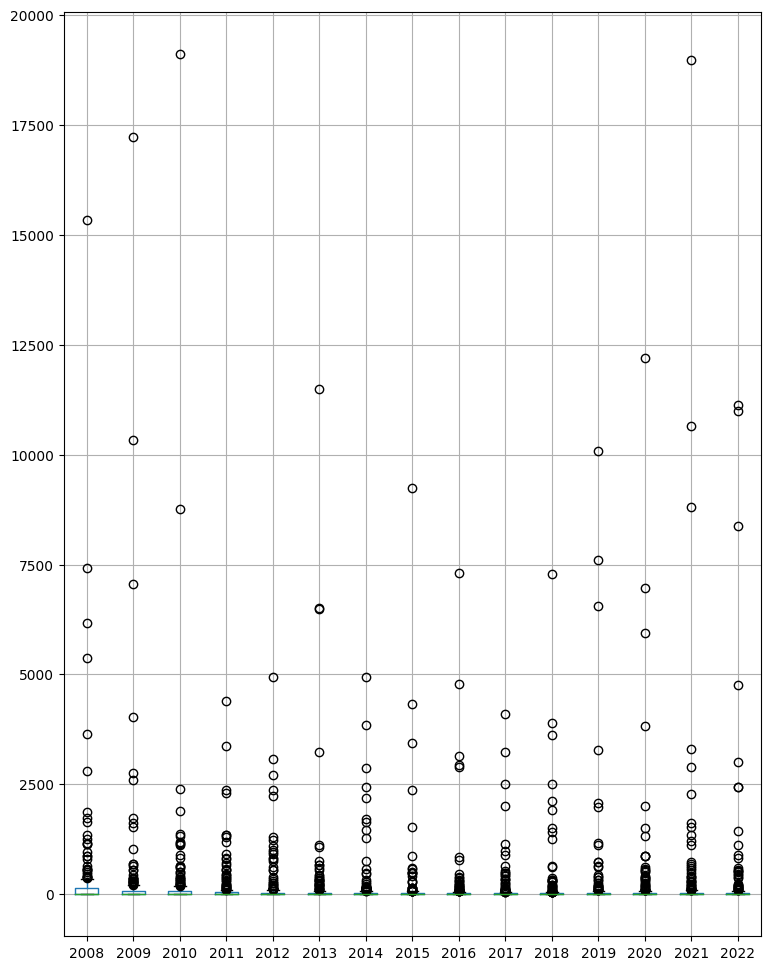

In [44]:
df[range(2008,2023)].boxplot(figsize=(9,12))

Boxplot dos dados modificados. Ao invés de ser os dados puros de desmatamento, são as porcentagens da área desmatada de cada UC, ao longo dos anos. Dados não-acumulativos.

<Axes: >

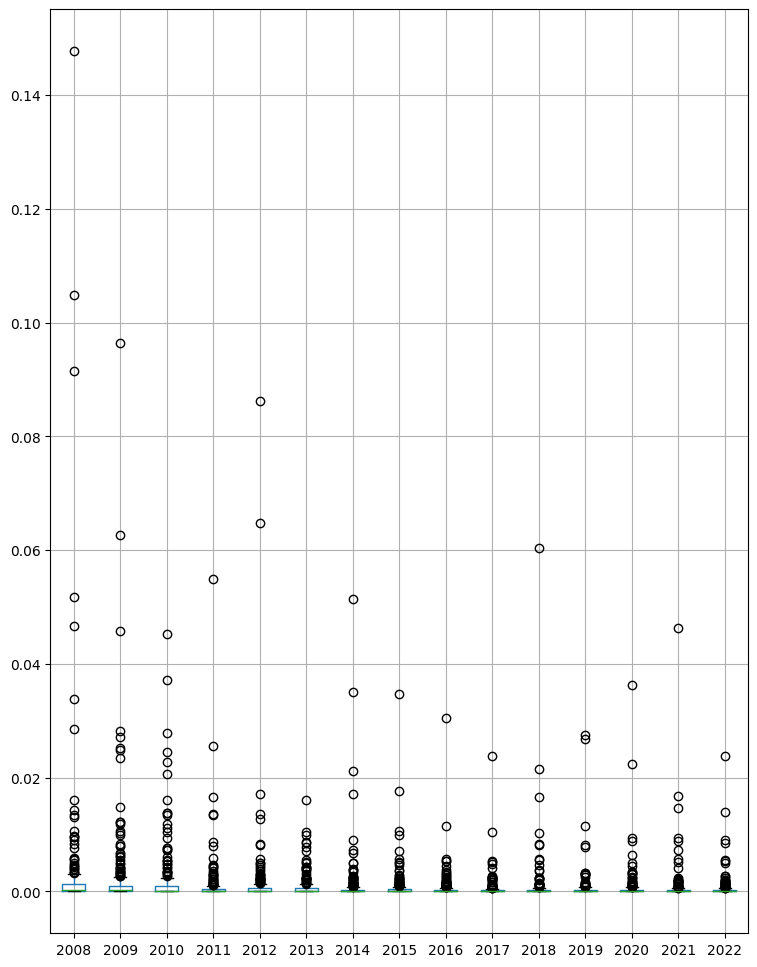

In [45]:
dft = df.copy()
dft.loc[:,range(2008,2023)] = dft.loc[:,range(2008,2023)].apply(lambda x: x/dft['área_ha_uc'])
dft[range(2008,2023)].boxplot(figsize=(9,12))

Os boxplots apresentados mostram claramente vários outliers presentes no dataset, porém, contrário do que normalmente se pensaria, esses dados são relevantes e não devem ser excluídos do dataset.

As UCs possuem tamanhos muito diferentes, além de que a maioria das UCs não possuem uma área de milhares de hectares, que é o caso de certas UCs localizadas na Amazônia. Portanto, mesmo sendo consideradas como outliers, essas Unidades de Conservação não devem ser retiradas do dataset, pois elas ainda são importantes para a análise dos dados. De qualquer forma, é importante que quem esteja vendo as análises sendo feitas aqui, tenha essa informação em mente.

### non-prep

#### Estatísticas descritivas dos dados com visualizações (apagar?)
(plots para análise)

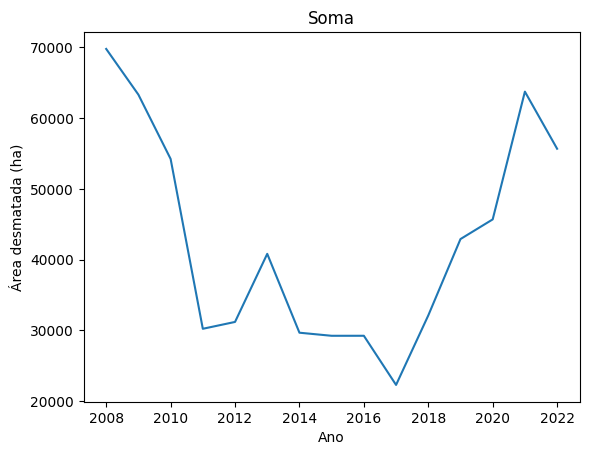

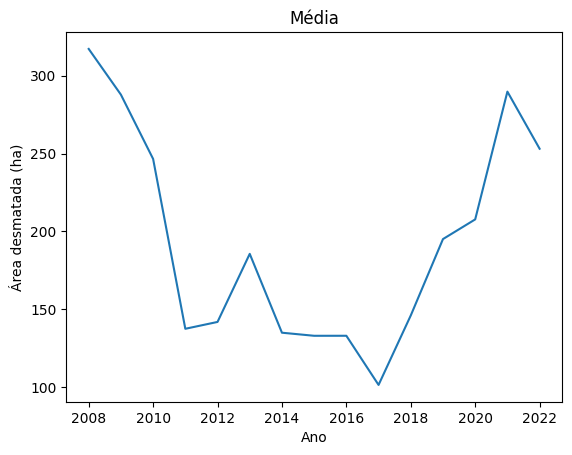

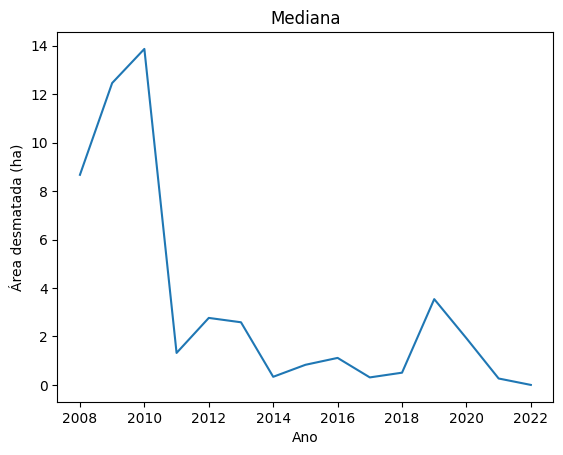

In [46]:
cols = list(range(2008,2023))

plt.title('Soma')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].sum())
plt.show()

plt.title('Média')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].mean())
plt.show()

plt.title('Mediana')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].median())
plt.show()

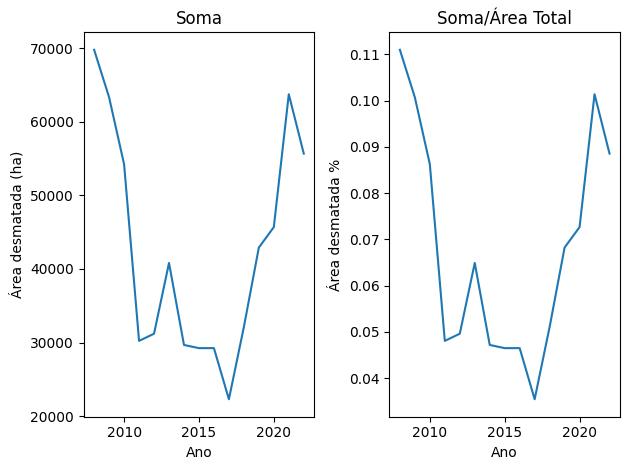

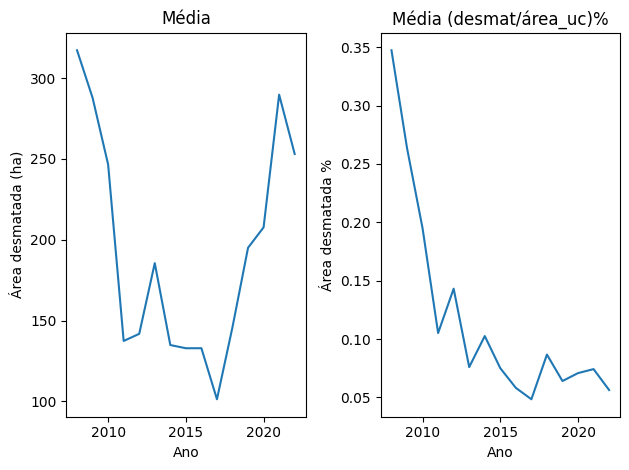

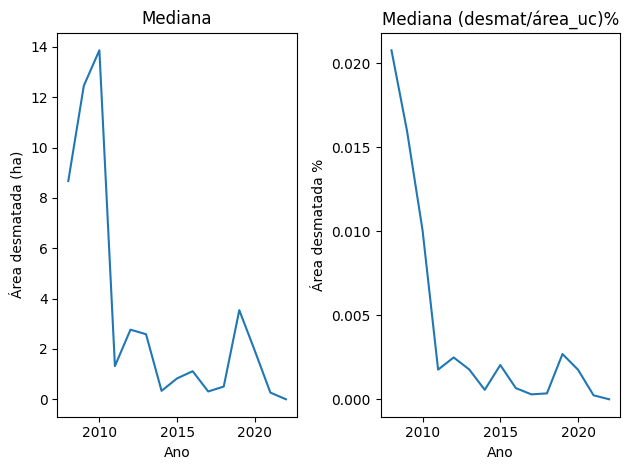

In [47]:
plt.subplot(1, 2, 1)
plt.title('Soma')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].sum())

plt.subplot(1, 2, 2)
plt.title('Soma/Área Total')
plt.xlabel('Ano')
plt.ylabel('Área desmatada %')
plt.plot(((df[cols]/df['área_ha_uc'].sum()).sum())*100)
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
plt.title('Média')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].mean())

plt.subplot(1, 2, 2)
plt.title('Média (desmat/área_uc)%')
plt.xlabel('Ano')
plt.ylabel('Área desmatada %')
plt.plot((dft[cols].mean())*100)
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
plt.title('Mediana')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].median())

plt.subplot(1, 2, 2)
plt.title('Mediana (desmat/área_uc)%')
plt.xlabel('Ano')
plt.ylabel('Área desmatada %')
plt.plot((dft[cols].median())*100)
plt.tight_layout()
plt.show()

In [48]:
df.describe()

,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
count,2.200000e+02,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,2.858424e+05,317.171682,287.801545,246.524409,137.433977,141.828227,185.556909,134.912636,132.934023,132.945182,101.376864,146.006091,195.052136,207.681818,289.740136,253.066136
std,5.417177e+05,1318.053681,1478.608911,1436.805255,477.048777,516.549560,1014.786521,547.484841,750.120562,682.176215,430.944896,671.759392,999.359699,1070.669826,1613.968412,1267.788918
min,8.918946e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.126207e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.754204e+04,8.670000,12.457500,13.865000,1.320000,2.765000,2.585000,0.335000,0.830000,1.115000,0.310000,0.505000,3.540000,1.925000,0.265000,0.000000
75%,2.790140e+05,137.987500,81.065000,78.360000,41.701250,37.013750,34.535000,31.337500,26.416250,27.122500,20.602500,21.912500,34.835000,37.115000,35.690000,30.770000
max,3.865169e+06,15344.820000,17225.680000,19106.540000,4403.495000,4938.450000,11482.350000,4934.850000,9250.500000,7305.890000,4106.880000,7280.340000,10073.500000,12198.600000,18982.120000,11140.010000


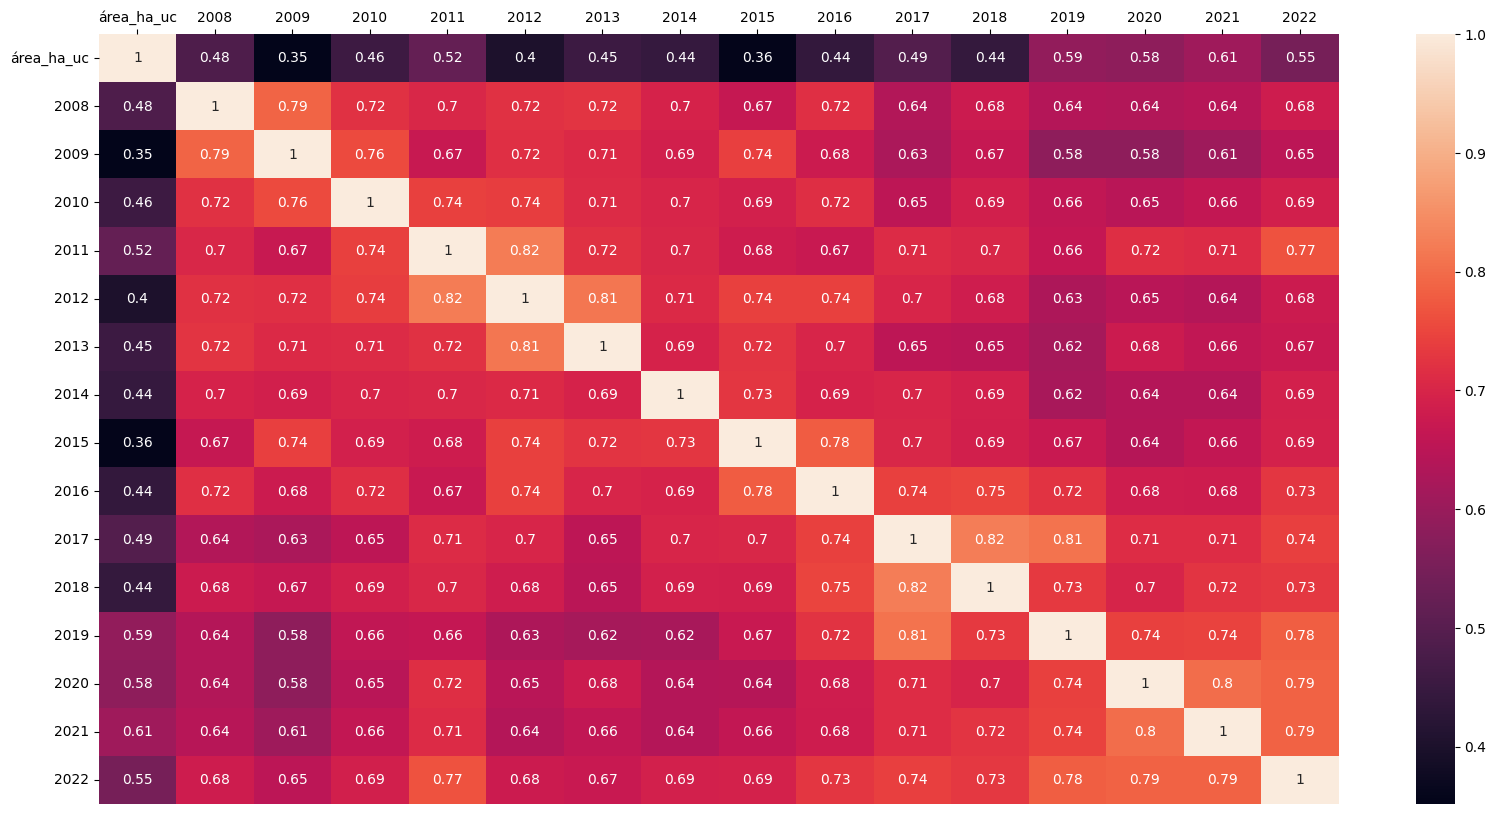

In [49]:
plt.figure(figsize=(20,10))
hm = sns.heatmap(df[['área_ha_uc'] + cols].corr(method='spearman'), annot=True)
hm.set(xlabel="", ylabel="")
hm.xaxis.tick_top()
plt.show()

Como esperado, a maioria das colunas são moderada/fortemente correlacionadas entre si. Além disso, parace ser que, o ano y no qual um ano x é mais correlacionado parece ser o ano seguinte.

E a que é geralmente menos correlacionada com outras é 'área_ha_uc', o que significa que o tamanho da UC de fato importa para a quantidade de seus hecctares desmatados, mas não tanto.

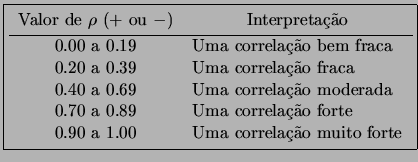

In [50]:
for col in colsa:
  _, p = stats.shapiro(df[col].apply(lambda x: log10(x) if x!=0 else 0))
  print(f"{col}: {p:.9f}")

área_ha_uc: 0.000008510
2008: 0.000000002
2009: 0.000000192
2010: 0.000000001
2011: 0.000000000
2012: 0.000000000
2013: 0.000000000
2014: 0.000000000
2015: 0.000000000
2016: 0.000000000
2017: 0.000000000
2018: 0.000000000
2019: 0.000000000
2020: 0.000000000
2021: 0.000000000
2022: 0.000000000


Transformar os valores das colunas em log10 também não as ajuda a alcançar a distribuição gaussiana.

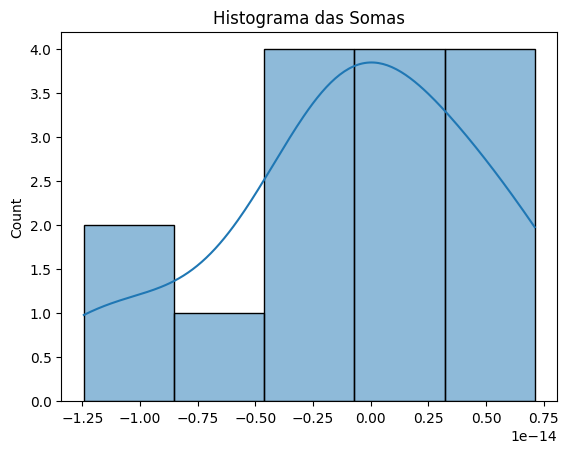

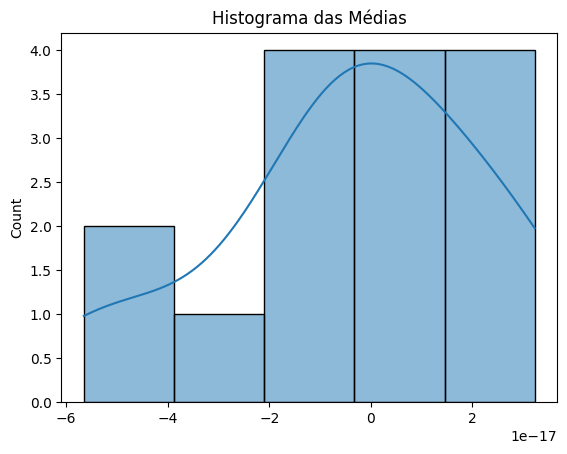

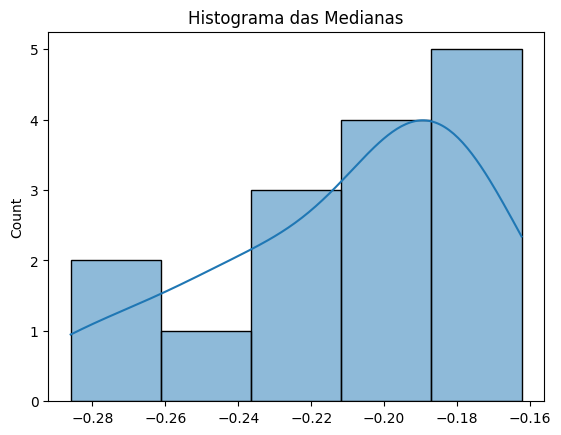

In [51]:
sns.histplot(df_norm[cols].sum(), kde=True)
plt.title('Histograma das Somas')
plt.show()

# Histograma das médias
sns.histplot(df_norm[cols].mean(), kde=True)
plt.title('Histograma das Médias')
plt.show()

# Histograma das medianas
sns.histplot(df_norm[cols].median(), kde=True)
plt.title('Histograma das Medianas')
plt.show()

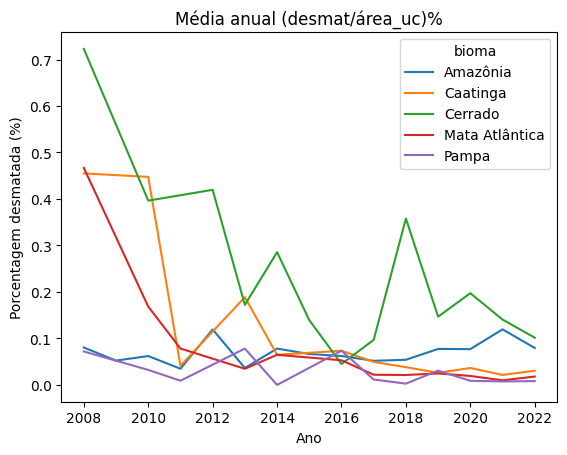

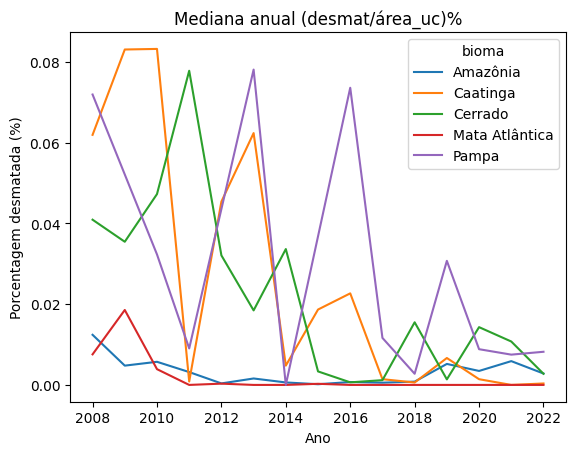

In [52]:
colsb = cols + ['bioma']
grupobi = dft[colsb].groupby(by='bioma')

(grupobi.aggregate('mean')*100).T.plot.line()
plt.xlabel('Ano')
plt.ylabel('Porcentagem desmatada (%)')
plt.title('Média anual (desmat/área_uc)%')

(grupobi.aggregate('median')*100).T.plot.line()
plt.xlabel('Ano')
plt.ylabel('Porcentagem desmatada (%)')
plt.title('Mediana anual (desmat/área_uc)%');

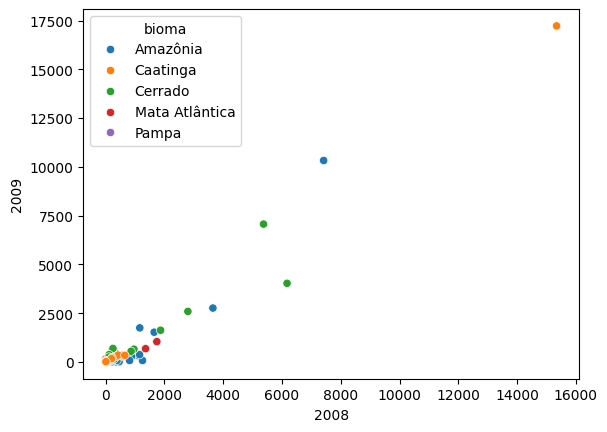

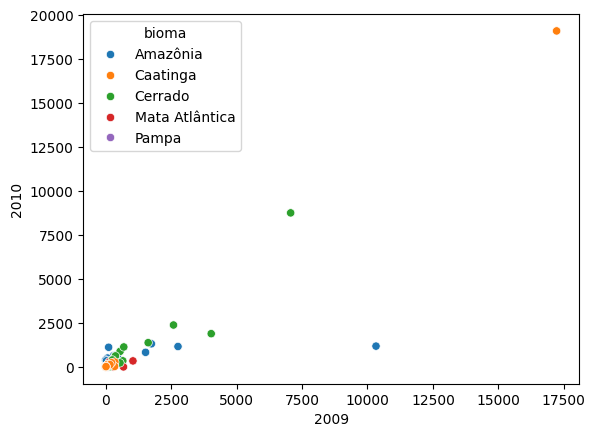

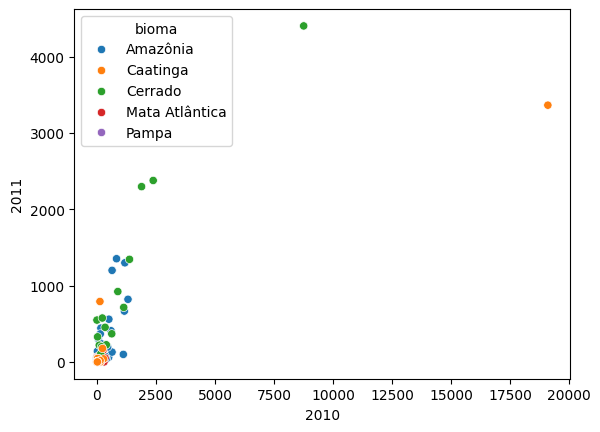

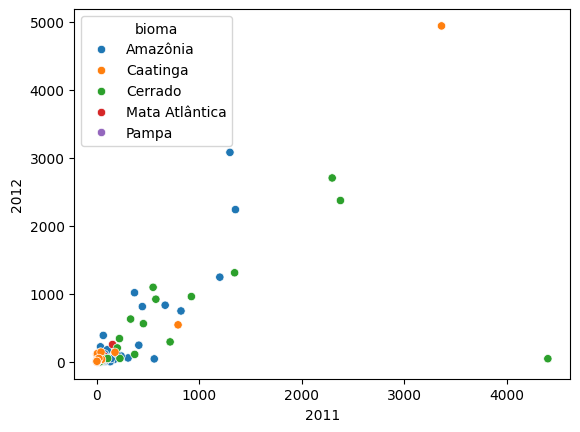

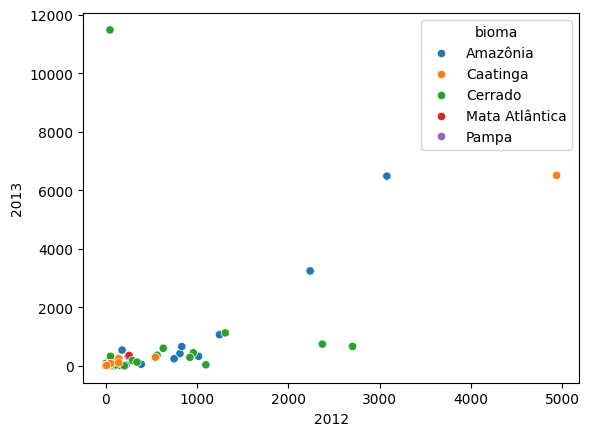

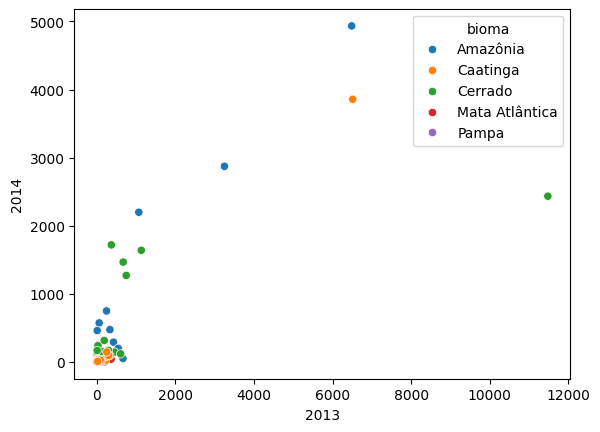

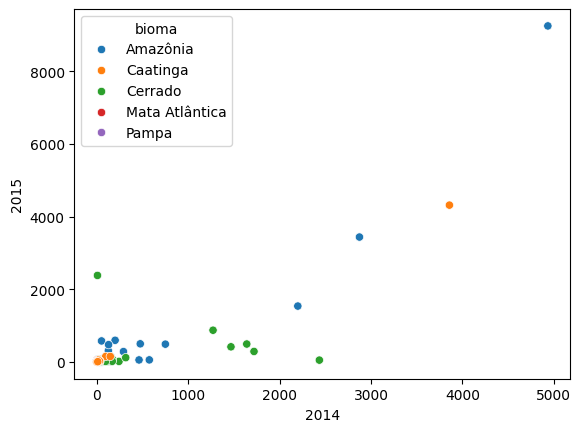

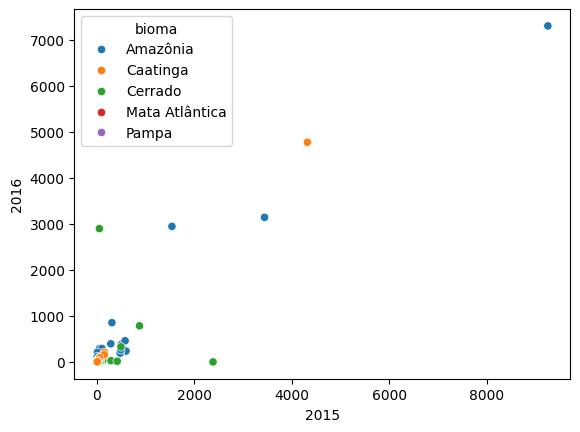

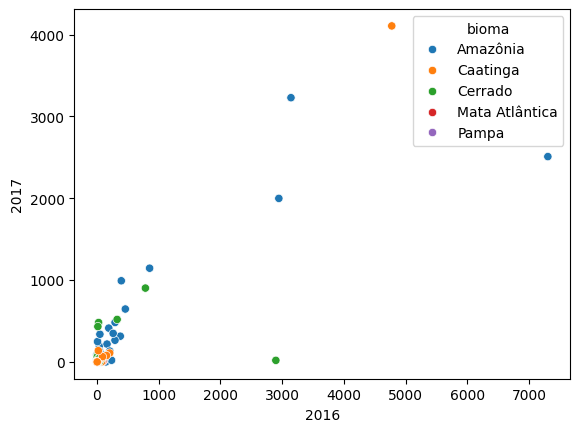

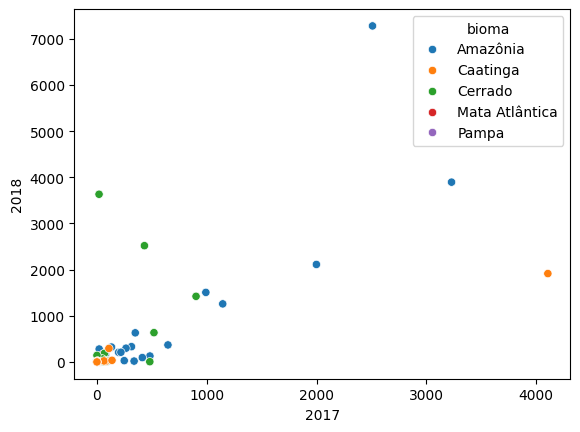

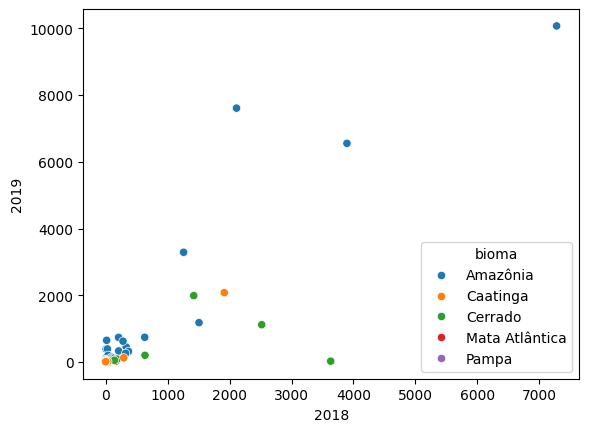

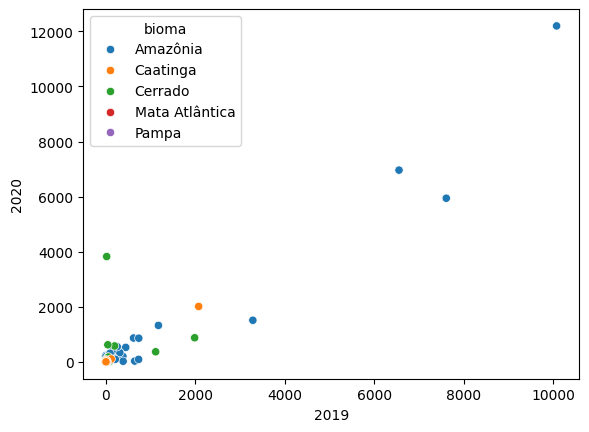

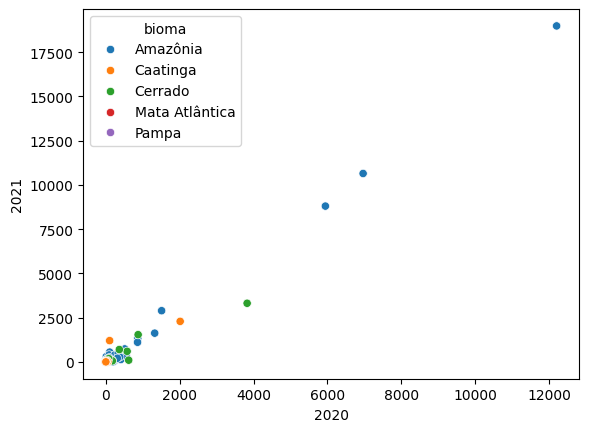

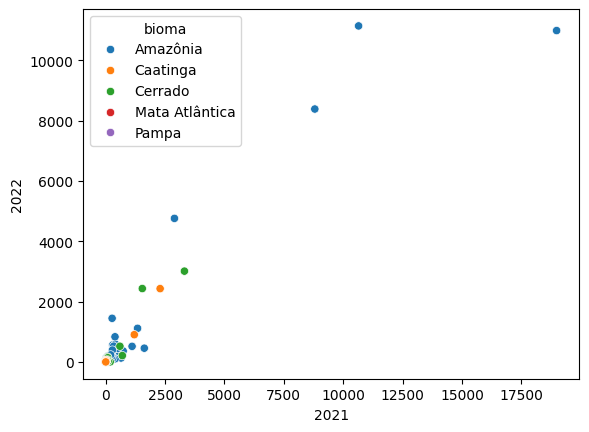

In [53]:
for ano in range(2008, 2022):
  sns.scatterplot(df, x=ano, y=(ano+1), hue='bioma')
  plt.show()

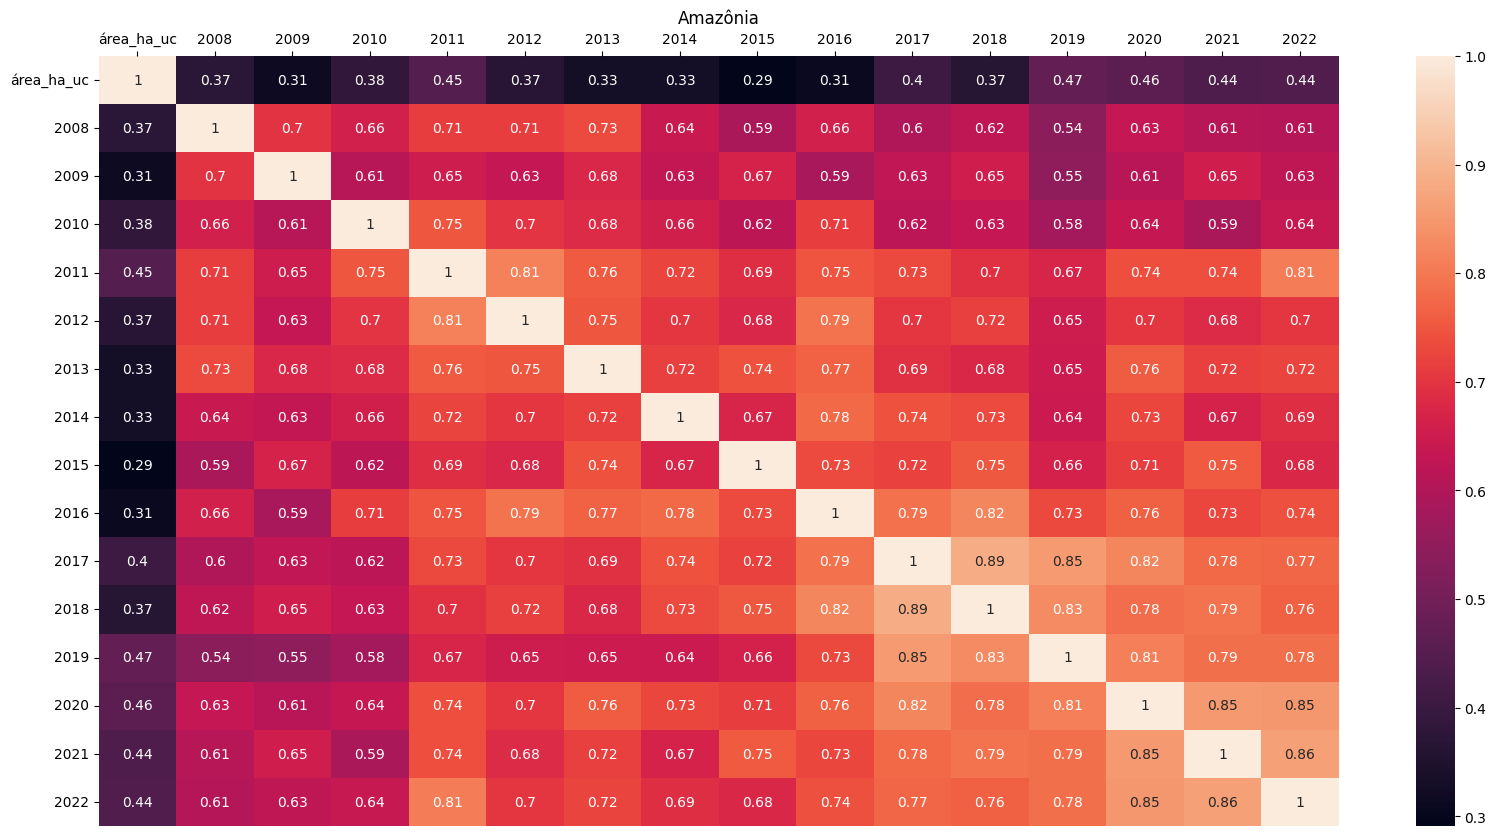

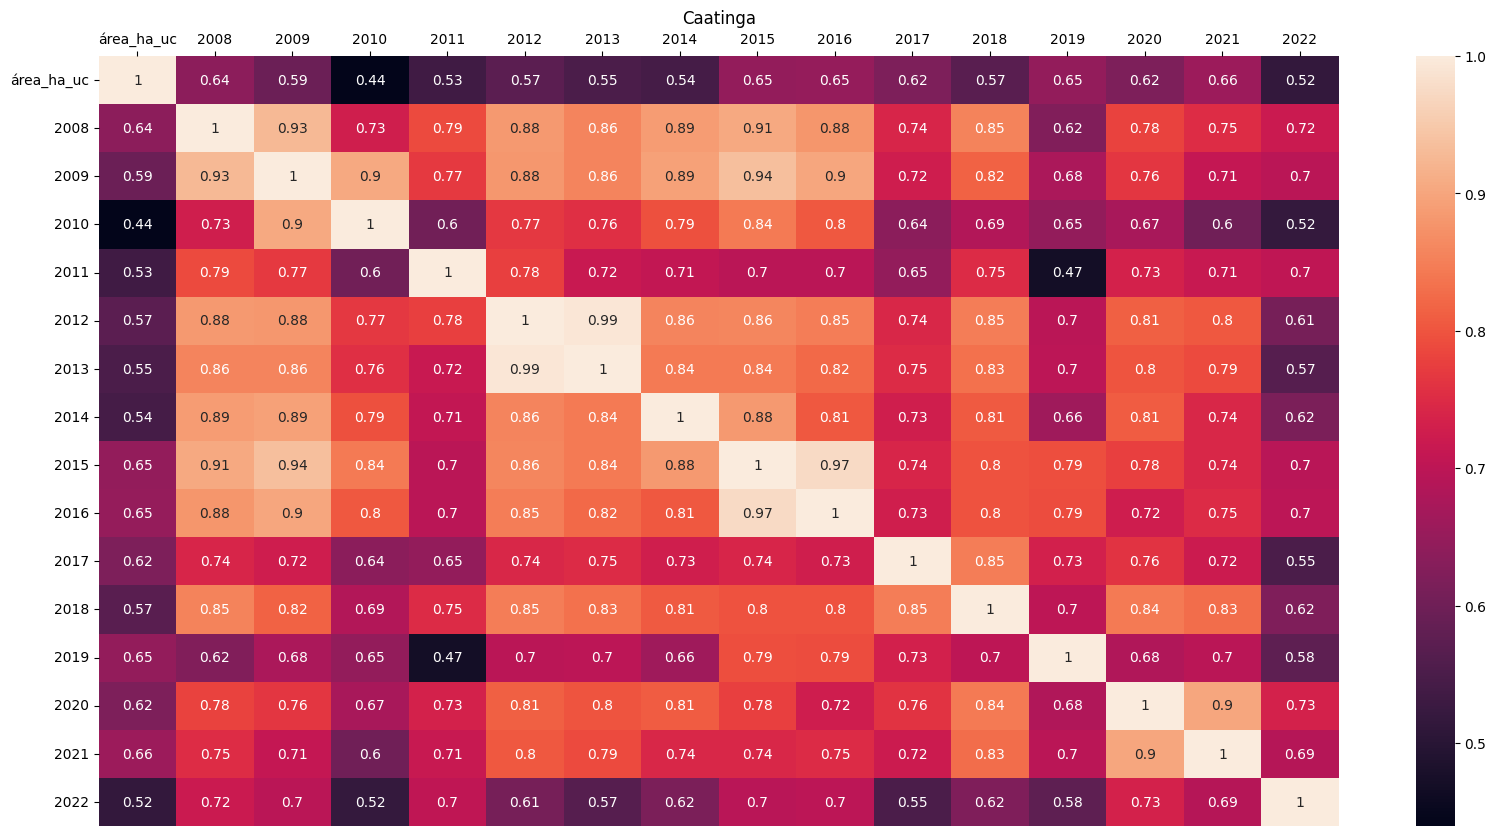

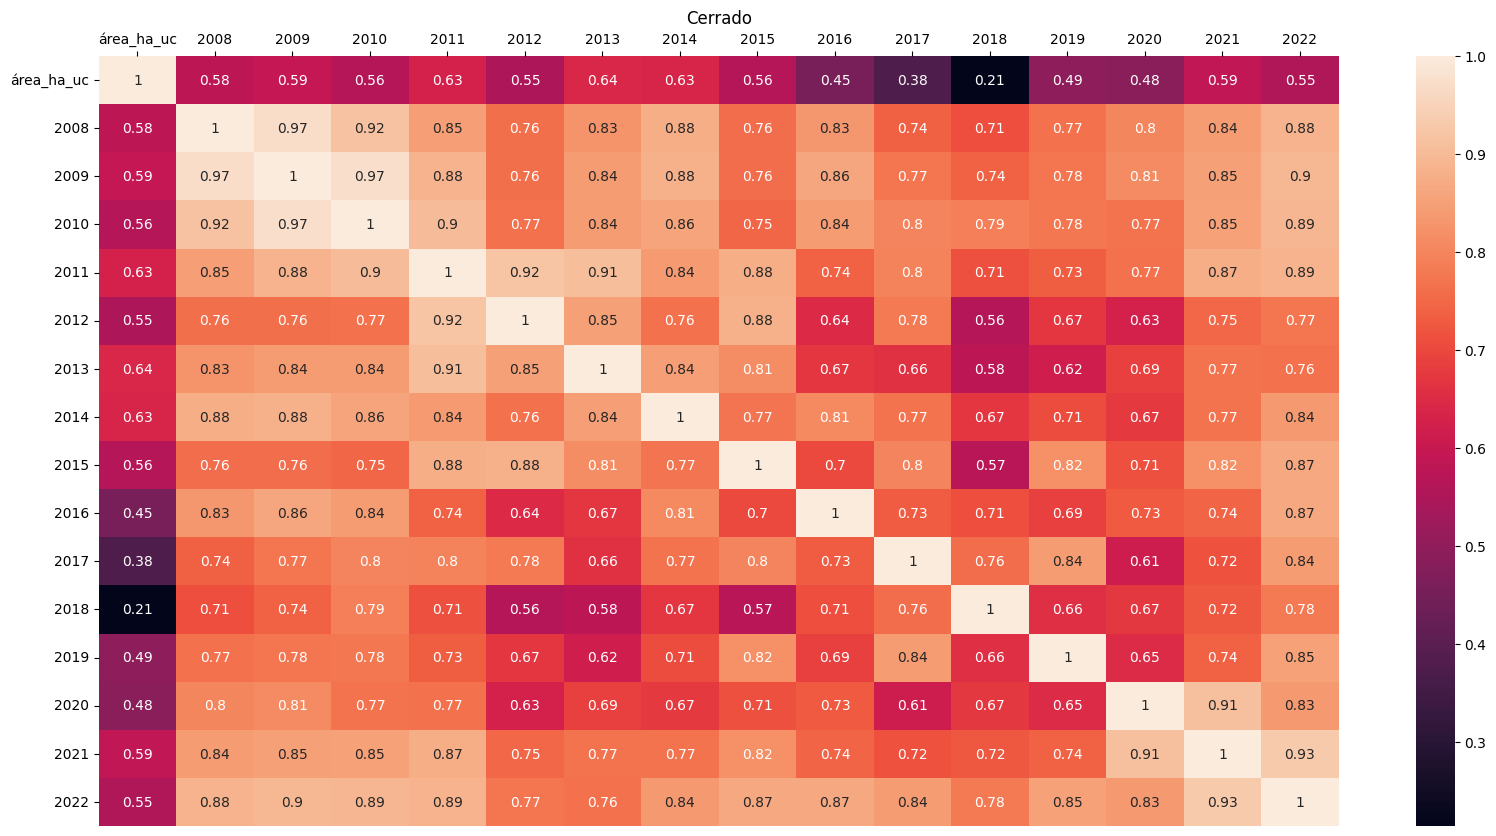

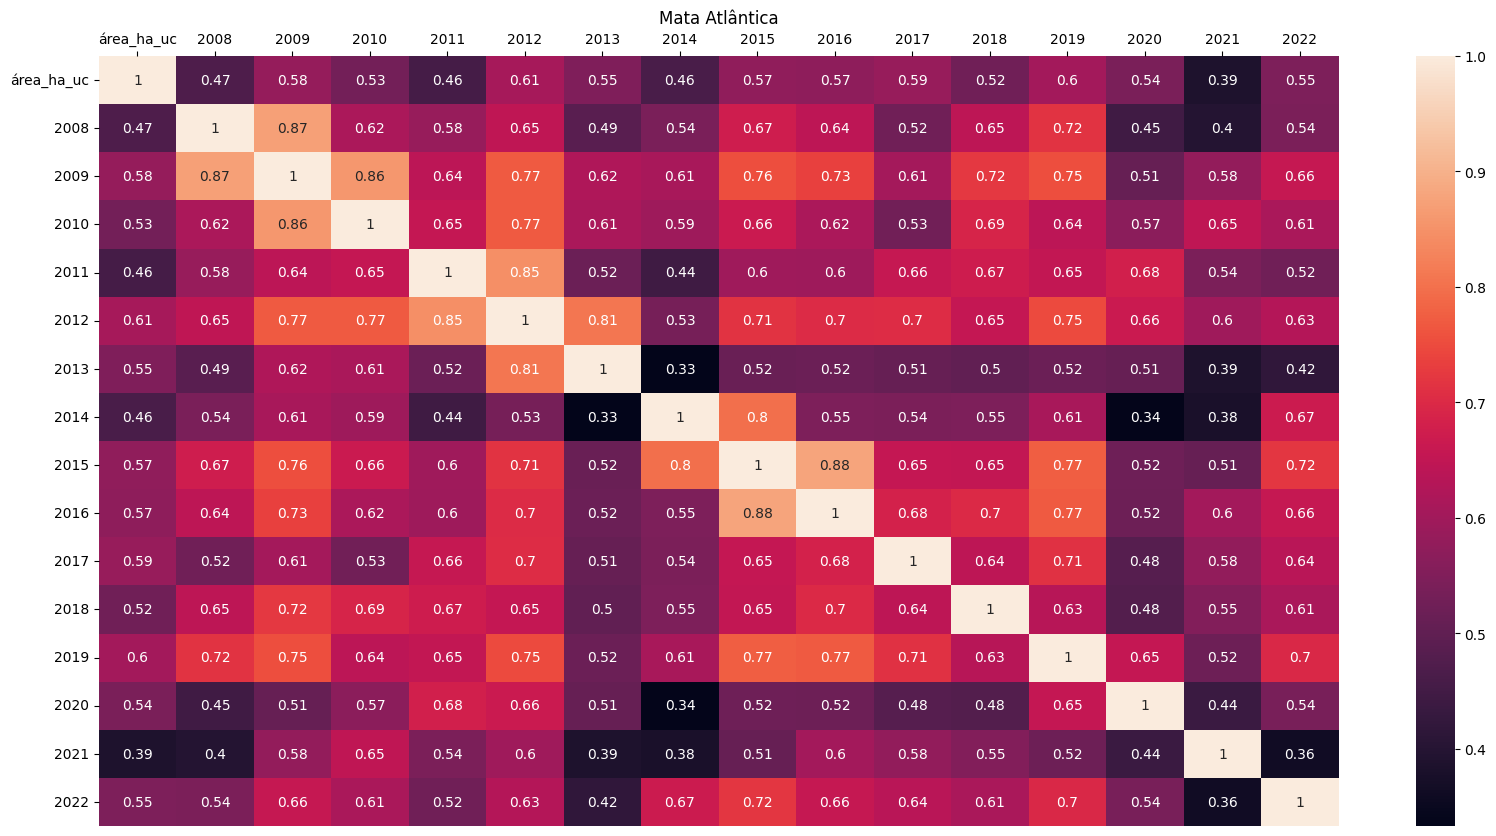

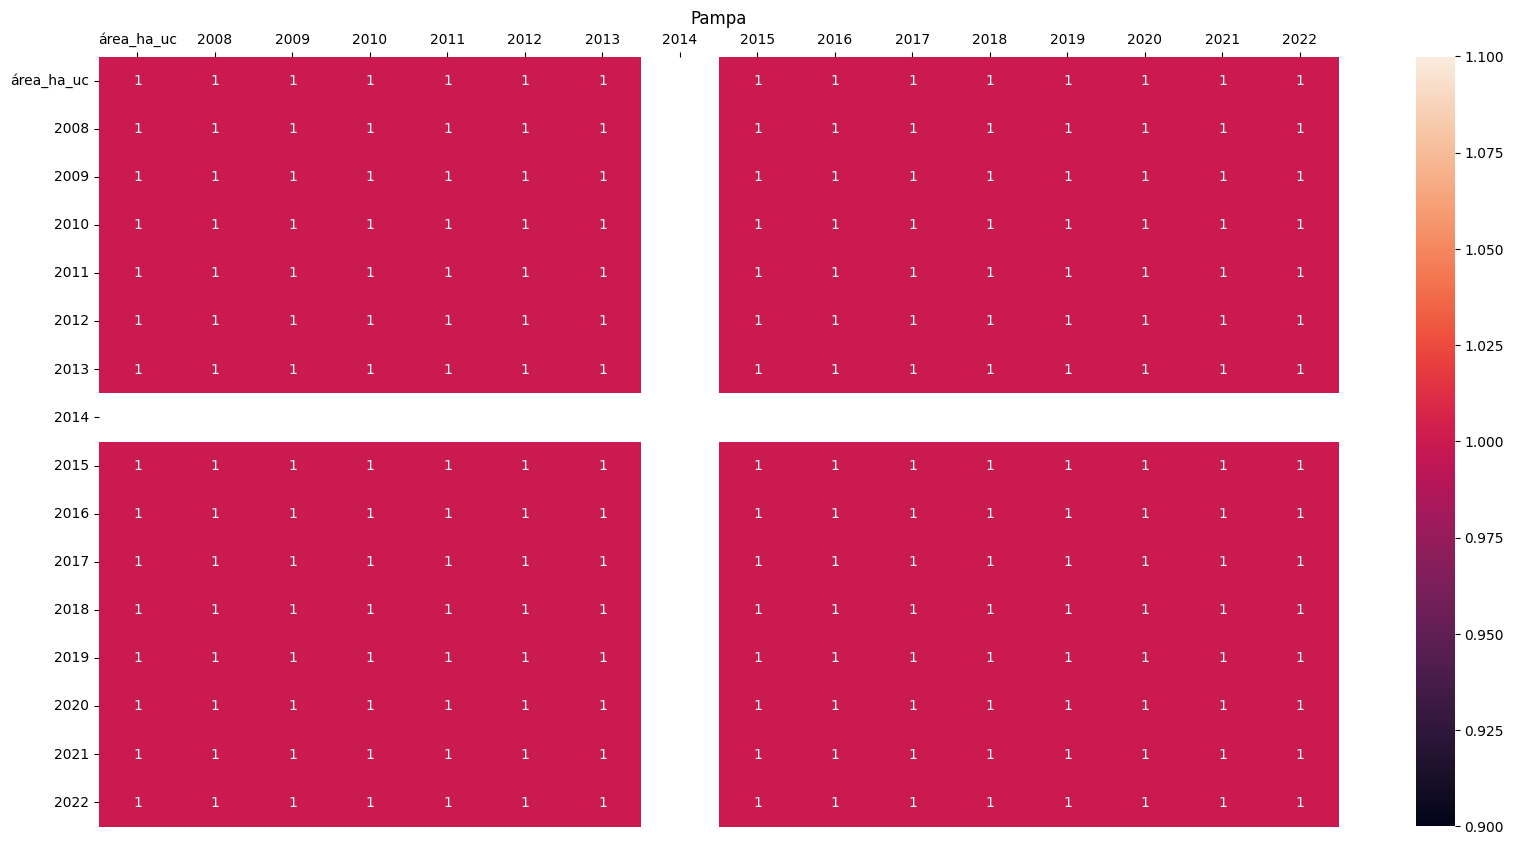

In [54]:
for b in df.bioma.cat.categories:
  plt.figure(figsize=(20,10))
  hm = sns.heatmap(df.loc[(df.bioma==b),(['área_ha_uc'] + cols)].corr(method='spearman'), annot=True)
  hm.set(xlabel="", ylabel="", title=b)
  hm.xaxis.tick_top()
  plt.show()

O bioma da Pampa apresentou esta correlação porque o dataset só possui duas UCs localizadas nesse bioma.

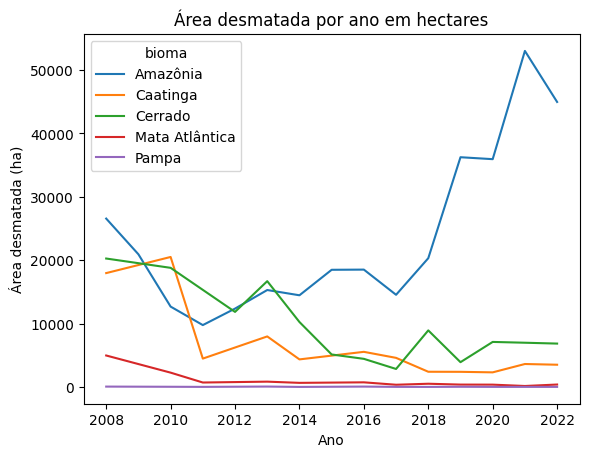

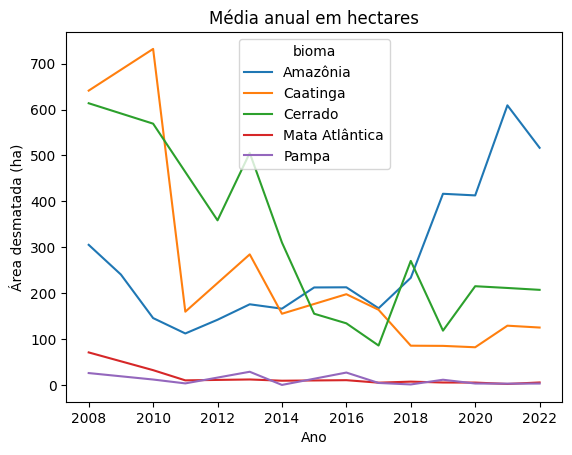

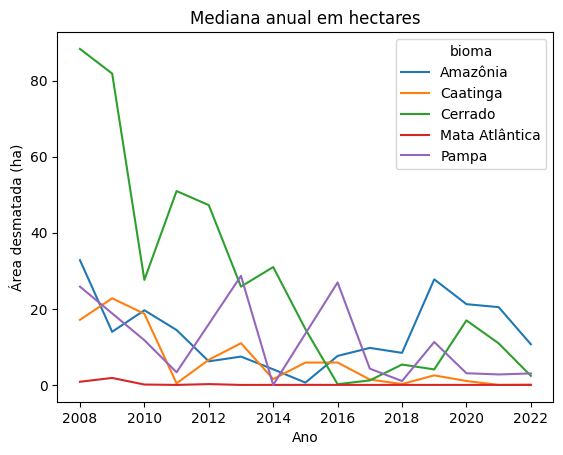

In [55]:
grupobi = df[colsb].groupby(by='bioma')
#sns.lineplot(df[colsb].groupby(by='bioma').aggregate('mean').T)

grupobi.aggregate('sum').T.plot.line()
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.title('Área desmatada por ano em hectares')

grupobi.aggregate('mean').T.plot.line()
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.title('Média anual em hectares')

grupobi.aggregate('median').T.plot.line()
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.title('Mediana anual em hectares');

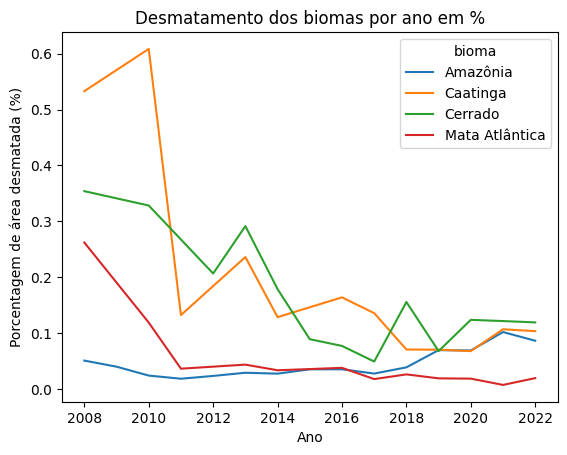

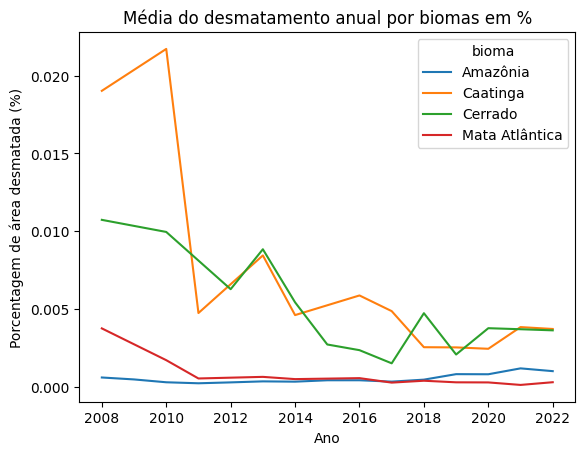

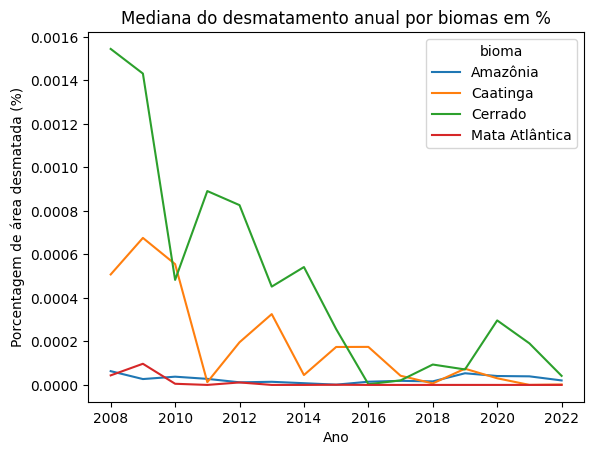

In [56]:
areasbi = np.array(df[['área_ha_uc', 'bioma']].groupby(by='bioma').aggregate('sum').T)
bms = ['Amazônia', 'Caatinga', 'Cerrado', 'Mata Atlântica']

((grupobi.aggregate('sum').T/areasbi)*100)[bms].plot.line()
plt.xlabel('Ano')
plt.ylabel('Porcentagem de área desmatada (%)')
plt.title('Desmatamento dos biomas por ano em %')

((grupobi.aggregate('mean').T/areasbi)*100)[bms].plot.line()
plt.xlabel('Ano')
plt.ylabel('Porcentagem de área desmatada (%)')
plt.title('Média do desmatamento anual por biomas em %')

((grupobi.aggregate('median').T/areasbi)*100)[bms].plot.line()
plt.xlabel('Ano')
plt.ylabel('Porcentagem de área desmatada (%)')
plt.title('Mediana do desmatamento anual por biomas em %');

# Modelos e previsões

* Árvore de Decisão (dtree)
* Random Forest (rforest)
* K-Nearest-Neighbours (knn)
* [?] Support Vector Machine (svm)

Opções de colunas para previsão:

1. ```2022```: Quantidade de hectares desmatados em 2022 de uma UC (mas talvez esteja indo mais a fundo de processamento de séries temporais)
  * Regressão
  * Classificação (se fizer discretização da coluna)

2. ```bioma```: Bioma a qual uma UC pertence com base nos dados do desmatamento
  * Classificação

#### Manipulações

In [57]:
seed = randint(0, 4294967295)
print('Seed:', seed)

Seed: 2335493977


In [58]:
df['bioma'].value_counts()

bioma
Amazônia          87
Mata Atlântica    70
Cerrado           33
Caatinga          28
Pampa              2
Name: count, dtype: int64

In [59]:
df.bioma.cat.categories

Index(['Amazônia', 'Caatinga', 'Cerrado', 'Mata Atlântica', 'Pampa'], dtype='object')

In [60]:
X = df[colsa]
y = df['bioma'].cat.codes # coluna escolhida

In [61]:
new_X = X.copy()
new_y = y.copy()

new_X.columns = new_X.columns.astype(str)
new_X = pd.concat([new_X, new_X.loc[y==4,:], new_X.loc[y==4,:]], ignore_index=True)
new_y = pd.concat([new_y, pd.Series([4]*4)], ignore_index=True)

In [62]:
smote = SMOTE(random_state=42, sampling_strategy='not majority')
new_X, new_y = smote.fit_resample(new_X, new_y)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.3, random_state=seed, shuffle=True)
X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(X_train, y_train, test_size=0.5, random_state=seed, shuffle=True)

logging:

In [64]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

k_scores:

In [65]:
k_scores_cross = {}

### Árvore de Decisão

In [66]:
#construindo o espaco de busca por configuracoes do classificador
criterion = ['entropy', 'gini']
max_depth = [2,5,7,10,12,15,17,20]
min_samples_split = [5,10,15,20,30,40,50,60]

k_scores_cross['dtree'] = []

In [67]:
# Validation with MLFlow
for c in criterion:
  for md in max_depth:
    for mss in min_samples_split:
      with mlflow.start_run():
        # training model:
        tmodel = DecisionTreeClassifier(criterion=c, max_depth=md, min_samples_split=mss, random_state=seed).fit(X_train_sub, y_train_sub)
        #scores = cross_val_score(tmodel, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
        #k_scores_cross['dtree'].append(scores.mean())

        # accuracy, precision, recall, f1-score
        train_scores = checkMetrics(y_train_sub, tmodel.predict(X_train_sub))
        valid_scores = checkMetrics(y_valid, tmodel.predict(X_valid))

        print(f'''
[{c}\t|\t{md}\t|\t{mss}]
         \t\tTreinamento\t| Validação
Acurácia:\t{train_scores[0]}\t|  {valid_scores[0]}
Precisão:\t{train_scores[1]}\t|  {valid_scores[1]}
Recall:  \t{train_scores[2]}\t|  {valid_scores[2]}
F1-Score:\t{train_scores[3]}\t|  {valid_scores[3]}
''')

        # Substituindo melhores scores e modelo:
        #if(k_scores_cross['dtree'][-1] > k_best):
        #  k_best = k_scores_cross['dtree'][-1]
        #  tree_best = [c, md, mss]
        #  dtree = tmodel

        mlflow.log_param("criterion", c)
        mlflow.log_param("max_depth", md)
        mlflow.log_param("min_samples_split", mss)
        mlflow.log_metric("train_accuracy", train_scores[0])
        mlflow.log_metric("train_precision", train_scores[1])
        mlflow.log_metric("train_recall", train_scores[2])
        mlflow.log_metric("train_f1_score", train_scores[3])
        mlflow.log_metric("valid_accuracy", valid_scores[0])
        mlflow.log_metric("valid_precision", valid_scores[1])
        mlflow.log_metric("valid_recall", valid_scores[2])
        mlflow.log_metric("valid_f1_score", valid_scores[3])

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":

            # Register the model
            # There are other ways to use the Model Registry, which depends on the use case,
            # please refer to the doc for more information:
            # https://mlflow.org/docs/latest/model-registry.html#api-workflow
            mlflow.sklearn.log_model(tmodel, "model", registered_model_name="DecisionTreeModel")
        else:
            mlflow.sklearn.log_model(tmodel, "model")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	2	|	5]
         		Treinamento	| Validação
Acurácia:	0.5723684210526315	|  0.5131578947368421
Precisão:	0.35753041601255886	|  0.3073655705996131
Recall:  	0.5429435483870968	|  0.49444444444444446
F1-Score:	0.4277613240418119	|  0.3771795590232127



/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	2	|	10]
         		Treinamento	| Validação
Acurácia:	0.5723684210526315	|  0.5131578947368421
Precisão:	0.35753041601255886	|  0.3073655705996131
Recall:  	0.5429435483870968	|  0.49444444444444446
F1-Score:	0.4277613240418119	|  0.3771795590232127



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	2	|	15]
         		Treinamento	| Validação
Acurácia:	0.5723684210526315	|  0.5131578947368421
Precisão:	0.35753041601255886	|  0.3073655705996131
Recall:  	0.5429435483870968	|  0.49444444444444446
F1-Score:	0.4277613240418119	|  0.3771795590232127



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	2	|	20]
         		Treinamento	| Validação
Acurácia:	0.5723684210526315	|  0.5131578947368421
Precisão:	0.35753041601255886	|  0.3073655705996131
Recall:  	0.5429435483870968	|  0.49444444444444446
F1-Score:	0.4277613240418119	|  0.3771795590232127



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	2	|	30]
         		Treinamento	| Validação
Acurácia:	0.5723684210526315	|  0.5131578947368421
Precisão:	0.35753041601255886	|  0.3073655705996131
Recall:  	0.5429435483870968	|  0.49444444444444446
F1-Score:	0.4277613240418119	|  0.3771795590232127



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	2	|	40]
         		Treinamento	| Validação
Acurácia:	0.5723684210526315	|  0.5131578947368421
Precisão:	0.35753041601255886	|  0.3073655705996131
Recall:  	0.5429435483870968	|  0.49444444444444446
F1-Score:	0.4277613240418119	|  0.3771795590232127



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	2	|	50]
         		Treinamento	| Validação
Acurácia:	0.5723684210526315	|  0.5131578947368421
Precisão:	0.35753041601255886	|  0.3073655705996131
Recall:  	0.5429435483870968	|  0.49444444444444446
F1-Score:	0.4277613240418119	|  0.3771795590232127



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	2	|	60]
         		Treinamento	| Validação
Acurácia:	0.5723684210526315	|  0.5131578947368421
Precisão:	0.35753041601255886	|  0.3073655705996131
Recall:  	0.5429435483870968	|  0.49444444444444446
F1-Score:	0.4277613240418119	|  0.3771795590232127


[entropy	|	5	|	5]
         		Treinamento	| Validação
Acurácia:	0.875	|  0.6052631578947368
Precisão:	0.8820039682539683	|  0.6042518421839738
Recall:  	0.8649679487179487	|  0.5907142857142856
F1-Score:	0.8627435064935065	|  0.5765787408199745


[entropy	|	5	|	10]
         		Treinamento	| Validação
Acurácia:	0.8486842105263158	|  0.5986842105263158
Precisão:	0.8634182705340201	|  0.6011576200642643
Recall:  	0.8368951612903226	|  0.5886587301587302
F1-Score:	0.8335888842340455	|  0.5712610313662945


[entropy	|	5	|	15]
         		Treinamento	| Validação
Acurácia:	0.8486842105263158	|  0.5921052631578947
Precisão:	0.8634182705340201	|  0.5939781328847771
Recall:  	0.8368951612903226	|  0.5824087301587302
F1-Score:	0.833588884234

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	5	|	50]
         		Treinamento	| Validação
Acurácia:	0.631578947368421	|  0.5592105263157895
Precisão:	0.5077008705580134	|  0.4595560467900893
Recall:  	0.6179435483870968	|  0.535515873015873
F1-Score:	0.5493574338816287	|  0.46887934859534275



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	5	|	60]
         		Treinamento	| Validação
Acurácia:	0.631578947368421	|  0.5592105263157895
Precisão:	0.5077008705580134	|  0.4595560467900893
Recall:  	0.6179435483870968	|  0.535515873015873
F1-Score:	0.5493574338816287	|  0.46887934859534275


[entropy	|	7	|	5]
         		Treinamento	| Validação
Acurácia:	0.9539473684210527	|  0.6447368421052632
Precisão:	0.9569609134826524	|  0.6470031194295901
Recall:  	0.9492307692307692	|  0.6386309523809525
F1-Score:	0.9510508150628674	|  0.6352447477354664


[entropy	|	7	|	10]
         		Treinamento	| Validação
Acurácia:	0.8947368421052632	|  0.6447368421052632
Precisão:	0.9051136363636363	|  0.6790733125354509
Recall:  	0.886606699751861	|  0.6411031746031746
F1-Score:	0.8893005002587546	|  0.6307693201053363


[entropy	|	7	|	15]
         		Treinamento	| Validação
Acurácia:	0.868421052631579	|  0.6052631578947368
Precisão:	0.8789528680635759	|  0.6206186406186406
Recall:  	0.8620233664185276	|  0.5982460317460317
F1-Score:	0.8636

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	7	|	50]
         		Treinamento	| Validação
Acurácia:	0.631578947368421	|  0.5592105263157895
Precisão:	0.5077008705580134	|  0.4595560467900893
Recall:  	0.6179435483870968	|  0.535515873015873
F1-Score:	0.5493574338816287	|  0.46887934859534275



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	7	|	60]
         		Treinamento	| Validação
Acurácia:	0.631578947368421	|  0.5592105263157895
Precisão:	0.5077008705580134	|  0.4595560467900893
Recall:  	0.6179435483870968	|  0.535515873015873
F1-Score:	0.5493574338816287	|  0.46887934859534275


[entropy	|	10	|	5]
         		Treinamento	| Validação
Acurácia:	0.9736842105263158	|  0.625
Precisão:	0.9739364801864803	|  0.6182060118244329
Recall:  	0.972724358974359	|  0.6149563492063492
F1-Score:	0.9729111405835544	|  0.6114084959999813


[entropy	|	10	|	10]
         		Treinamento	| Validação
Acurácia:	0.9013157894736842	|  0.631578947368421
Precisão:	0.9046807359307358	|  0.6474274099883857
Recall:  	0.8957413151364765	|  0.6277103174603175
F1-Score:	0.8978678528060821	|  0.6115719014878679


[entropy	|	10	|	15]
         		Treinamento	| Validação
Acurácia:	0.868421052631579	|  0.6052631578947368
Precisão:	0.8789528680635759	|  0.6206186406186406
Recall:  	0.8620233664185276	|  0.5982460317460317
F1-Score:	0.863640308582449

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	10	|	50]
         		Treinamento	| Validação
Acurácia:	0.631578947368421	|  0.5592105263157895
Precisão:	0.5077008705580134	|  0.4595560467900893
Recall:  	0.6179435483870968	|  0.535515873015873
F1-Score:	0.5493574338816287	|  0.46887934859534275



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	10	|	60]
         		Treinamento	| Validação
Acurácia:	0.631578947368421	|  0.5592105263157895
Precisão:	0.5077008705580134	|  0.4595560467900893
Recall:  	0.6179435483870968	|  0.535515873015873
F1-Score:	0.5493574338816287	|  0.46887934859534275


[entropy	|	12	|	5]
         		Treinamento	| Validação
Acurácia:	0.9736842105263158	|  0.625
Precisão:	0.9739364801864803	|  0.6182060118244329
Recall:  	0.972724358974359	|  0.6149563492063492
F1-Score:	0.9729111405835544	|  0.6114084959999813


[entropy	|	12	|	10]
         		Treinamento	| Validação
Acurácia:	0.9013157894736842	|  0.631578947368421
Precisão:	0.9046807359307358	|  0.6474274099883857
Recall:  	0.8957413151364765	|  0.6277103174603175
F1-Score:	0.8978678528060821	|  0.6115719014878679


[entropy	|	12	|	15]
         		Treinamento	| Validação
Acurácia:	0.868421052631579	|  0.6052631578947368
Precisão:	0.8789528680635759	|  0.6206186406186406
Recall:  	0.8620233664185276	|  0.5982460317460317
F1-Score:	0.86364030858244

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	12	|	50]
         		Treinamento	| Validação
Acurácia:	0.631578947368421	|  0.5592105263157895
Precisão:	0.5077008705580134	|  0.4595560467900893
Recall:  	0.6179435483870968	|  0.535515873015873
F1-Score:	0.5493574338816287	|  0.46887934859534275



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	12	|	60]
         		Treinamento	| Validação
Acurácia:	0.631578947368421	|  0.5592105263157895
Precisão:	0.5077008705580134	|  0.4595560467900893
Recall:  	0.6179435483870968	|  0.535515873015873
F1-Score:	0.5493574338816287	|  0.46887934859534275


[entropy	|	15	|	5]
         		Treinamento	| Validação
Acurácia:	0.9736842105263158	|  0.625
Precisão:	0.9739364801864803	|  0.6182060118244329
Recall:  	0.972724358974359	|  0.6149563492063492
F1-Score:	0.9729111405835544	|  0.6114084959999813


[entropy	|	15	|	10]
         		Treinamento	| Validação
Acurácia:	0.9013157894736842	|  0.631578947368421
Precisão:	0.9046807359307358	|  0.6474274099883857
Recall:  	0.8957413151364765	|  0.6277103174603175
F1-Score:	0.8978678528060821	|  0.6115719014878679


[entropy	|	15	|	15]
         		Treinamento	| Validação
Acurácia:	0.868421052631579	|  0.6052631578947368
Precisão:	0.8789528680635759	|  0.6206186406186406
Recall:  	0.8620233664185276	|  0.5982460317460317
F1-Score:	0.86364030858244

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	15	|	50]
         		Treinamento	| Validação
Acurácia:	0.631578947368421	|  0.5592105263157895
Precisão:	0.5077008705580134	|  0.4595560467900893
Recall:  	0.6179435483870968	|  0.535515873015873
F1-Score:	0.5493574338816287	|  0.46887934859534275



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	15	|	60]
         		Treinamento	| Validação
Acurácia:	0.631578947368421	|  0.5592105263157895
Precisão:	0.5077008705580134	|  0.4595560467900893
Recall:  	0.6179435483870968	|  0.535515873015873
F1-Score:	0.5493574338816287	|  0.46887934859534275


[entropy	|	17	|	5]
         		Treinamento	| Validação
Acurácia:	0.9736842105263158	|  0.625
Precisão:	0.9739364801864803	|  0.6182060118244329
Recall:  	0.972724358974359	|  0.6149563492063492
F1-Score:	0.9729111405835544	|  0.6114084959999813


[entropy	|	17	|	10]
         		Treinamento	| Validação
Acurácia:	0.9013157894736842	|  0.631578947368421
Precisão:	0.9046807359307358	|  0.6474274099883857
Recall:  	0.8957413151364765	|  0.6277103174603175
F1-Score:	0.8978678528060821	|  0.6115719014878679


[entropy	|	17	|	15]
         		Treinamento	| Validação
Acurácia:	0.868421052631579	|  0.6052631578947368
Precisão:	0.8789528680635759	|  0.6206186406186406
Recall:  	0.8620233664185276	|  0.5982460317460317
F1-Score:	0.86364030858244

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	17	|	50]
         		Treinamento	| Validação
Acurácia:	0.631578947368421	|  0.5592105263157895
Precisão:	0.5077008705580134	|  0.4595560467900893
Recall:  	0.6179435483870968	|  0.535515873015873
F1-Score:	0.5493574338816287	|  0.46887934859534275



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	17	|	60]
         		Treinamento	| Validação
Acurácia:	0.631578947368421	|  0.5592105263157895
Precisão:	0.5077008705580134	|  0.4595560467900893
Recall:  	0.6179435483870968	|  0.535515873015873
F1-Score:	0.5493574338816287	|  0.46887934859534275


[entropy	|	20	|	5]
         		Treinamento	| Validação
Acurácia:	0.9736842105263158	|  0.625
Precisão:	0.9739364801864803	|  0.6182060118244329
Recall:  	0.972724358974359	|  0.6149563492063492
F1-Score:	0.9729111405835544	|  0.6114084959999813


[entropy	|	20	|	10]
         		Treinamento	| Validação
Acurácia:	0.9013157894736842	|  0.631578947368421
Precisão:	0.9046807359307358	|  0.6474274099883857
Recall:  	0.8957413151364765	|  0.6277103174603175
F1-Score:	0.8978678528060821	|  0.6115719014878679


[entropy	|	20	|	15]
         		Treinamento	| Validação
Acurácia:	0.868421052631579	|  0.6052631578947368
Precisão:	0.8789528680635759	|  0.6206186406186406
Recall:  	0.8620233664185276	|  0.5982460317460317
F1-Score:	0.86364030858244

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	20	|	50]
         		Treinamento	| Validação
Acurácia:	0.631578947368421	|  0.5592105263157895
Precisão:	0.5077008705580134	|  0.4595560467900893
Recall:  	0.6179435483870968	|  0.535515873015873
F1-Score:	0.5493574338816287	|  0.46887934859534275



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[entropy	|	20	|	60]
         		Treinamento	| Validação
Acurácia:	0.631578947368421	|  0.5592105263157895
Precisão:	0.5077008705580134	|  0.4595560467900893
Recall:  	0.6179435483870968	|  0.535515873015873
F1-Score:	0.5493574338816287	|  0.46887934859534275



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[gini	|	2	|	5]
         		Treinamento	| Validação
Acurácia:	0.5855263157894737	|  0.5263157894736842
Precisão:	0.5048124057315234	|  0.4179798850574713
Recall:  	0.5573521505376344	|  0.5177777777777777
F1-Score:	0.49475913621262463	|  0.4363663220900498



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[gini	|	2	|	10]
         		Treinamento	| Validação
Acurácia:	0.5855263157894737	|  0.5263157894736842
Precisão:	0.5048124057315234	|  0.4179798850574713
Recall:  	0.5573521505376344	|  0.5177777777777777
F1-Score:	0.49475913621262463	|  0.4363663220900498



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[gini	|	2	|	15]
         		Treinamento	| Validação
Acurácia:	0.5855263157894737	|  0.5263157894736842
Precisão:	0.5048124057315234	|  0.4179798850574713
Recall:  	0.5573521505376344	|  0.5177777777777777
F1-Score:	0.49475913621262463	|  0.4363663220900498



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[gini	|	2	|	20]
         		Treinamento	| Validação
Acurácia:	0.5855263157894737	|  0.5263157894736842
Precisão:	0.5048124057315234	|  0.4179798850574713
Recall:  	0.5573521505376344	|  0.5177777777777777
F1-Score:	0.49475913621262463	|  0.4363663220900498



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[gini	|	2	|	30]
         		Treinamento	| Validação
Acurácia:	0.5855263157894737	|  0.5263157894736842
Precisão:	0.5048124057315234	|  0.4179798850574713
Recall:  	0.5573521505376344	|  0.5177777777777777
F1-Score:	0.49475913621262463	|  0.4363663220900498



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[gini	|	2	|	40]
         		Treinamento	| Validação
Acurácia:	0.5723684210526315	|  0.5131578947368421
Precisão:	0.3597327106518283	|  0.30907836990595616
Recall:  	0.5429435483870968	|  0.49444444444444446
F1-Score:	0.42846638655462177	|  0.37701815038893693



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[gini	|	2	|	50]
         		Treinamento	| Validação
Acurácia:	0.5723684210526315	|  0.5131578947368421
Precisão:	0.3597327106518283	|  0.30907836990595616
Recall:  	0.5429435483870968	|  0.49444444444444446
F1-Score:	0.42846638655462177	|  0.37701815038893693



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[gini	|	2	|	60]
         		Treinamento	| Validação
Acurácia:	0.5723684210526315	|  0.5131578947368421
Precisão:	0.3597327106518283	|  0.30907836990595616
Recall:  	0.5429435483870968	|  0.49444444444444446
F1-Score:	0.42846638655462177	|  0.37701815038893693


[gini	|	5	|	5]
         		Treinamento	| Validação
Acurácia:	0.881578947368421	|  0.6644736842105263
Precisão:	0.8780767651888342	|  0.6527944862155388
Recall:  	0.8798759305210918	|  0.6503015873015874
F1-Score:	0.8781401179074368	|  0.641945756015415


[gini	|	5	|	10]
         		Treinamento	| Validação
Acurácia:	0.8486842105263158	|  0.631578947368421
Precisão:	0.846923597025017	|  0.614500909718301
Recall:  	0.8434656741108354	|  0.6166071428571429
F1-Score:	0.8447238486560519	|  0.6051102117210458


[gini	|	5	|	15]
         		Treinamento	| Validação
Acurácia:	0.8157894736842105	|  0.625
Precisão:	0.8233836777954426	|  0.6110791925465839
Recall:  	0.8114226633581472	|  0.6183849206349207
F1-Score:	0.8126784260515603	|  0.60692

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[gini	|	5	|	60]
         		Treinamento	| Validação
Acurácia:	0.6381578947368421	|  0.5789473684210527
Precisão:	0.5093917446858623	|  0.47302582474996263
Recall:  	0.6299627791563276	|  0.554265873015873
F1-Score:	0.560210302332582	|  0.49375483971748324


[gini	|	7	|	5]
         		Treinamento	| Validação
Acurácia:	0.9276315789473685	|  0.6710526315789473
Precisão:	0.9253101736972706	|  0.6620807562142608
Recall:  	0.9256865177832919	|  0.6591587301587302
F1-Score:	0.9254041862714523	|  0.6516490270958356


[gini	|	7	|	10]
         		Treinamento	| Validação
Acurácia:	0.8618421052631579	|  0.6447368421052632
Precisão:	0.8666314496314496	|  0.6526984126984128
Recall:  	0.8557506203473946	|  0.6324801587301587
F1-Score:	0.858520092226614	|  0.6290393816709606


[gini	|	7	|	15]
         		Treinamento	| Validação
Acurácia:	0.8223684210526315	|  0.625
Precisão:	0.8283284193284194	|  0.6106346971862906
Recall:  	0.817874276261373	|  0.6183849206349207
F1-Score:	0.8192019025750369	|  0.606381

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[gini	|	7	|	60]
         		Treinamento	| Validação
Acurácia:	0.6381578947368421	|  0.5789473684210527
Precisão:	0.5093917446858623	|  0.47302582474996263
Recall:  	0.6299627791563276	|  0.554265873015873
F1-Score:	0.560210302332582	|  0.49375483971748324


[gini	|	10	|	5]
         		Treinamento	| Validação
Acurácia:	0.9276315789473685	|  0.6710526315789473
Precisão:	0.9253101736972706	|  0.6620807562142608
Recall:  	0.9256865177832919	|  0.6591587301587302
F1-Score:	0.9254041862714523	|  0.6516490270958356


[gini	|	10	|	10]
         		Treinamento	| Validação
Acurácia:	0.8618421052631579	|  0.6447368421052632
Precisão:	0.8666314496314496	|  0.6526984126984128
Recall:  	0.8557506203473946	|  0.6324801587301587
F1-Score:	0.858520092226614	|  0.6290393816709606


[gini	|	10	|	15]
         		Treinamento	| Validação
Acurácia:	0.8223684210526315	|  0.625
Precisão:	0.8283284193284194	|  0.6106346971862906
Recall:  	0.817874276261373	|  0.6183849206349207
F1-Score:	0.8192019025750369	|  0.606

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[gini	|	10	|	60]
         		Treinamento	| Validação
Acurácia:	0.6381578947368421	|  0.5789473684210527
Precisão:	0.5093917446858623	|  0.47302582474996263
Recall:  	0.6299627791563276	|  0.554265873015873
F1-Score:	0.560210302332582	|  0.49375483971748324


[gini	|	12	|	5]
         		Treinamento	| Validação
Acurácia:	0.9276315789473685	|  0.6710526315789473
Precisão:	0.9253101736972706	|  0.6620807562142608
Recall:  	0.9256865177832919	|  0.6591587301587302
F1-Score:	0.9254041862714523	|  0.6516490270958356


[gini	|	12	|	10]
         		Treinamento	| Validação
Acurácia:	0.8618421052631579	|  0.6447368421052632
Precisão:	0.8666314496314496	|  0.6526984126984128
Recall:  	0.8557506203473946	|  0.6324801587301587
F1-Score:	0.858520092226614	|  0.6290393816709606


[gini	|	12	|	15]
         		Treinamento	| Validação
Acurácia:	0.8223684210526315	|  0.625
Precisão:	0.8283284193284194	|  0.6106346971862906
Recall:  	0.817874276261373	|  0.6183849206349207
F1-Score:	0.8192019025750369	|  0.60

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[gini	|	12	|	60]
         		Treinamento	| Validação
Acurácia:	0.6381578947368421	|  0.5789473684210527
Precisão:	0.5093917446858623	|  0.47302582474996263
Recall:  	0.6299627791563276	|  0.554265873015873
F1-Score:	0.560210302332582	|  0.49375483971748324


[gini	|	15	|	5]
         		Treinamento	| Validação
Acurácia:	0.9276315789473685	|  0.6710526315789473
Precisão:	0.9253101736972706	|  0.6620807562142608
Recall:  	0.9256865177832919	|  0.6591587301587302
F1-Score:	0.9254041862714523	|  0.6516490270958356


[gini	|	15	|	10]
         		Treinamento	| Validação
Acurácia:	0.8618421052631579	|  0.6447368421052632
Precisão:	0.8666314496314496	|  0.6526984126984128
Recall:  	0.8557506203473946	|  0.6324801587301587
F1-Score:	0.858520092226614	|  0.6290393816709606


[gini	|	15	|	15]
         		Treinamento	| Validação
Acurácia:	0.8223684210526315	|  0.625
Precisão:	0.8283284193284194	|  0.6106346971862906
Recall:  	0.817874276261373	|  0.6183849206349207
F1-Score:	0.8192019025750369	|  0.60

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[gini	|	15	|	60]
         		Treinamento	| Validação
Acurácia:	0.6381578947368421	|  0.5789473684210527
Precisão:	0.5093917446858623	|  0.47302582474996263
Recall:  	0.6299627791563276	|  0.554265873015873
F1-Score:	0.560210302332582	|  0.49375483971748324


[gini	|	17	|	5]
         		Treinamento	| Validação
Acurácia:	0.9276315789473685	|  0.6710526315789473
Precisão:	0.9253101736972706	|  0.6620807562142608
Recall:  	0.9256865177832919	|  0.6591587301587302
F1-Score:	0.9254041862714523	|  0.6516490270958356


[gini	|	17	|	10]
         		Treinamento	| Validação
Acurácia:	0.8618421052631579	|  0.6447368421052632
Precisão:	0.8666314496314496	|  0.6526984126984128
Recall:  	0.8557506203473946	|  0.6324801587301587
F1-Score:	0.858520092226614	|  0.6290393816709606


[gini	|	17	|	15]
         		Treinamento	| Validação
Acurácia:	0.8223684210526315	|  0.625
Precisão:	0.8283284193284194	|  0.6106346971862906
Recall:  	0.817874276261373	|  0.6183849206349207
F1-Score:	0.8192019025750369	|  0.60

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[gini	|	17	|	60]
         		Treinamento	| Validação
Acurácia:	0.6381578947368421	|  0.5789473684210527
Precisão:	0.5093917446858623	|  0.47302582474996263
Recall:  	0.6299627791563276	|  0.554265873015873
F1-Score:	0.560210302332582	|  0.49375483971748324


[gini	|	20	|	5]
         		Treinamento	| Validação
Acurácia:	0.9276315789473685	|  0.6710526315789473
Precisão:	0.9253101736972706	|  0.6620807562142608
Recall:  	0.9256865177832919	|  0.6591587301587302
F1-Score:	0.9254041862714523	|  0.6516490270958356


[gini	|	20	|	10]
         		Treinamento	| Validação
Acurácia:	0.8618421052631579	|  0.6447368421052632
Precisão:	0.8666314496314496	|  0.6526984126984128
Recall:  	0.8557506203473946	|  0.6324801587301587
F1-Score:	0.858520092226614	|  0.6290393816709606


[gini	|	20	|	15]
         		Treinamento	| Validação
Acurácia:	0.8223684210526315	|  0.625
Precisão:	0.8283284193284194	|  0.6106346971862906
Recall:  	0.817874276261373	|  0.6183849206349207
F1-Score:	0.8192019025750369	|  0.60

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[gini	|	20	|	60]
         		Treinamento	| Validação
Acurácia:	0.6381578947368421	|  0.5789473684210527
Precisão:	0.5093917446858623	|  0.47302582474996263
Recall:  	0.6299627791563276	|  0.554265873015873
F1-Score:	0.560210302332582	|  0.49375483971748324



In [68]:
warnings.filterwarnings("ignore")
#np.random.seed(40)

alpha = 1 #float(sys.argv[1]) if len(sys.argv) > 1 else 0.5
l1_ratio = 1 #float(sys.argv[2]) if len(sys.argv) > 2 else 0.5

with mlflow.start_run():
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(train_x, train_y)

    predicted_qualities = lr.predict(test_x)

    (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Model registry does not work with file store
    if tracking_url_type_store != "file":

        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(lr, "model", registered_model_name="ElasticnetWineModel")
    else:
        mlflow.sklearn.log_model(lr, "model")

NameError: name 'ElasticNet' is not defined

### Random Forest

In [70]:
# Random Forest
k_scores_cross['rforest'] = []
# Validation with MLFlow
for c in criterion:
  for md in max_depth:
    for mss in min_samples_split:
      with mlflow.start_run():
        # training model:
        rmodel = RandomForestClassifier(criterion=c, max_depth=md, min_samples_split=mss, random_state=seed).fit(X_train_sub, y_train_sub)
        #scores = cross_val_score(rmodel, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
        #k_scores_cross['rforest'].append(scores.mean())

        # accuracy, precision, recall, f1-score
        train_scores = checkMetrics(y_train_sub, rmodel.predict(X_train_sub))
        valid_scores = checkMetrics(y_valid, rmodel.predict(X_valid))

        print(f'''
[{c}\t|\t{md}\t|\t{mss}]
         \t\tTreinamento\t| Validação
Acurácia:\t{train_scores[0]}\t|  {valid_scores[0]}
Precisão:\t{train_scores[1]}\t|  {valid_scores[1]}
Recall:  \t{train_scores[2]}\t|  {valid_scores[2]}
F1-Score:\t{train_scores[3]}\t|  {valid_scores[3]}
''')

        # Substituindo melhores scores e modelo:
        #if(k_scores_cross['rforest'][-1] > k_best):
        #  k_best = k_scores_cross['rforest'][-1]
        #  rforest_best = [c, md, mss]
        #  rforest = rmodel

        mlflow.log_param("criterion", c)
        mlflow.log_param("max_depth", md)
        mlflow.log_param("min_samples_split", mss)
        mlflow.log_metric("train_accuracy", train_scores[0])
        mlflow.log_metric("train_precision", train_scores[1])
        mlflow.log_metric("train_recall", train_scores[2])
        mlflow.log_metric("train_f1_score", train_scores[3])
        mlflow.log_metric("valid_accuracy", valid_scores[0])
        mlflow.log_metric("valid_precision", valid_scores[1])
        mlflow.log_metric("valid_recall", valid_scores[2])
        mlflow.log_metric("valid_f1_score", valid_scores[3])

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":

            # Register the model
            # There are other ways to use the Model Registry, which depends on the use case,
            # please refer to the doc for more information:
            # https://mlflow.org/docs/latest/model-registry.html#api-workflow
            mlflow.sklearn.log_model(rmodel, "model", registered_model_name="RandomForestModel")
        else:
            mlflow.sklearn.log_model(rmodel, "model")



[entropy	|	2	|	5]
         		Treinamento	| Validação
Acurácia:	0.6644736842105263	|  0.5263157894736842
Precisão:	0.744812226301588	|  0.6439676113360324
Recall:  	0.6405944995864351	|  0.5256071428571428
F1-Score:	0.6054425814385549	|  0.479562020525876


[entropy	|	2	|	10]
         		Treinamento	| Validação
Acurácia:	0.6644736842105263	|  0.5263157894736842
Precisão:	0.744812226301588	|  0.6439676113360324
Recall:  	0.6405944995864351	|  0.5256071428571428
F1-Score:	0.6054425814385549	|  0.479562020525876


[entropy	|	2	|	15]
         		Treinamento	| Validação
Acurácia:	0.6578947368421053	|  0.5263157894736842
Precisão:	0.7411137910242054	|  0.6439676113360324
Recall:  	0.6339278329197684	|  0.5256071428571428
F1-Score:	0.5959089694783944	|  0.479562020525876


[entropy	|	2	|	20]
         		Treinamento	| Validação
Acurácia:	0.6644736842105263	|  0.5263157894736842
Precisão:	0.744812226301588	|  0.6439676113360324
Recall:  	0.6405944995864351	|  0.5256071428571428
F1-Score:	0.6054425

### KNN

In [72]:
# KNN
k_scores_cross['knn'] = []
# Validation with MLFlow
for k in range(2, 20):
  with mlflow.start_run():
    # training model:
    kmodel = KNeighborsClassifier(n_neighbors=k).fit(X_train_sub, y_train_sub)
    #scores = cross_val_score(kmodel, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
    #k_scores_cross['knn'].append(scores.mean())

    # accuracy, precision, recall, f1-score
    train_scores = checkMetrics(y_train_sub, kmodel.predict(X_train_sub))
    valid_scores = checkMetrics(y_valid, kmodel.predict(X_valid))

    print(f'''
[k = {k}]
         \t\tTreinamento\t| Validação
Acurácia:\t{train_scores[0]}\t|  {valid_scores[0]}
Precisão:\t{train_scores[1]}\t|  {valid_scores[1]}
Recall:  \t{train_scores[2]}\t|  {valid_scores[2]}
F1-Score:\t{train_scores[3]}\t|  {valid_scores[3]}
''')

    # Substituindo melhores scores e modelo:
    #if(k_scores_cross['knn'][-1] > k_best):
    #  k_best = k_scores_cross['knn'][-1]
    #  knn_best = k
    #  knn = kmodel

    mlflow.log_param("k", k)
    mlflow.log_metric("train_accuracy", train_scores[0])
    mlflow.log_metric("train_precision", train_scores[1])
    mlflow.log_metric("train_recall", train_scores[2])
    mlflow.log_metric("train_f1_score", train_scores[3])
    mlflow.log_metric("valid_accuracy", valid_scores[0])
    mlflow.log_metric("valid_precision", valid_scores[1])
    mlflow.log_metric("valid_recall", valid_scores[2])
    mlflow.log_metric("valid_f1_score", valid_scores[3])

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Model registry does not work with file store
    if tracking_url_type_store != "file":

        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(kmodel, "model", registered_model_name="KNNModel")
    else:
        mlflow.sklearn.log_model(kmodel, "model")



[k = 2]
         		Treinamento	| Validação
Acurácia:	0.7960526315789473	|  0.5131578947368421
Precisão:	0.8228841334104491	|  0.4579268879268879
Recall:  	0.7977564102564102	|  0.48614912954429085
F1-Score:	0.7805630220603984	|  0.45886654643014174


[k = 3]
         		Treinamento	| Validação
Acurácia:	0.7697368421052632	|  0.618421052631579
Precisão:	0.7588937883999176	|  0.6001864801864802
Recall:  	0.7632733664185276	|  0.6058214285714285
F1-Score:	0.757200480768307	|  0.59885615280595


[k = 4]
         		Treinamento	| Validação
Acurácia:	0.7236842105263158	|  0.5592105263157895
Precisão:	0.71043850216264	|  0.5321003584229391
Recall:  	0.7195275020678247	|  0.5451507936507938
F1-Score:	0.7128103044496485	|  0.5371088148998597


[k = 5]
         		Treinamento	| Validação
Acurácia:	0.6776315789473685	|  0.5592105263157895
Precisão:	0.6663732698215457	|  0.5483173601371358
Recall:  	0.6700217121588089	|  0.5525198412698413
F1-Score:	0.6662499082838066	|  0.5466715160838175


[k = 6]

### SVM

In [74]:
# prompt: SVM

from sklearn import svm

# Create a new SVM classifier with a linear kernel.
classifier = svm.SVC(kernel='linear', C=1.0)

# Train the classifier on the training data.
classifier.fit(X_train, y_train)

# Predict the labels of the test data.
y_pred = classifier.predict(X_test)

# Print the accuracy of the classifier.
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


Accuracy: 0.6412213740458015


### Resto?

In [ ]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2


if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    np.random.seed(40)

    # Read the wine-quality csv file from the URL
    csv_url = (
        "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    )
    try:
        data = pd.read_csv(csv_url, sep=";")
    except Exception as e:
        logger.exception(
            "Unable to download training & test CSV, check your internet connection. Error: %s", e
        )

    # Split the data into training and test sets. (0.75, 0.25) split.
    train, test = train_test_split(data)

    # The predicted column is "quality" which is a scalar from [3, 9]
    train_x = train.drop(["quality"], axis=1)
    test_x = test.drop(["quality"], axis=1)
    train_y = train[["quality"]]
    test_y = test[["quality"]]

    alpha = 1 #float(sys.argv[1]) if len(sys.argv) > 1 else 0.5
    l1_ratio = 1 #float(sys.argv[2]) if len(sys.argv) > 2 else 0.5

    with mlflow.start_run():
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        lr.fit(train_x, train_y)

        predicted_qualities = lr.predict(test_x)

        (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

        print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1_ratio", l1_ratio)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":

            # Register the model
            # There are other ways to use the Model Registry, which depends on the use case,
            # please refer to the doc for more information:
            # https://mlflow.org/docs/latest/model-registry.html#api-workflow
            mlflow.sklearn.log_model(lr, "model", registered_model_name="ElasticnetWineModel")
        else:
            mlflow.sklearn.log_model(lr, "model")

'''!ls -l mlruns/0/fb27c54b21a4452486670b7bd806d477/params'''

'''!less mlruns/0/fb27c54b21a4452486670b7bd806d477/metrics/mae'''